In [ ]:
!pip install -q transformers datasets nltk scikit-multilearn seaborn wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.8

In [ ]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import os
import warnings
from collections import Counter
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [ ]:
if torch.cuda.is_available():
    print(f"GPU доступен: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("GPU недоступен, используется CPU.")
    device = torch.device("cpu")

GPU доступен: Tesla T4


In [ ]:
train_path = '/content/train.csv'
test_path = '/content/test.csv'
submission_path = '/content/sample_submission.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_submission = pd.read_csv(submission_path)

In [ ]:
# Анализ Данных (EDA)

print("\nTrain Dataset:")
print(f"Размер: {df_train.shape}")
print("Info:")
df_train.info()
print("\nПропуски:", df_train.isnull().sum().sum())
print("\nПервые строки Train:")
display(df_train.head())

print("\nTest Dataset:")
print(f"Размер: {df_test.shape}")
print("Info:")
df_test.info()
print("\nПропуски:", df_test.isnull().sum().sum())
print("\nПервые строки Test:")
display(df_test.head())


Train Dataset:
Размер: (29568, 3)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29568 entries, 0 to 29567
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29568 non-null  int64 
 1   text    29568 non-null  object
 2   labels  29568 non-null  object
dtypes: int64(1), object(2)
memory usage: 693.1+ KB

Пропуски: 0

Первые строки Train:


id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                                                                                    text  \
0                      15 января\nДетская развлекательная программа\n15-00 бесплатно\n❗️\n@\ncafeotdyh\nКафе "Отдых"\n📍\nЗапись обязательно +73472228532   
1                                                                              13 и 14 августа\nВыходные в Меге\nhttps://t.me/megaufa_official\nМегапарк   
2                                                                                Йокнапатофа\nПостановка Театр им. Маяковского\nБилеты от 500 до 2000 р.   
3  Впервые в Уфе танцевальная терапия в группе с практикующим психологом\nТема встречи: «Отношения. Доверие. Контакт»\nПриходите, если:\n🔸\nвы хотите...   
4  🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня открытие IV Международного конкурса GRAND PIANO (для пианистов до 16 лет) в зале Чайковского.\nСего...   

                                    labels  
0  1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1  
1  0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1  
2  0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1  
3  1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0  
4  1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0


Test Dataset:
Размер: (7392, 2)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7392 entries, 0 to 7391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7392 non-null   int64 
 1   text    7392 non-null   object
dtypes: int64(1), object(1)
memory usage: 115.6+ KB

Пропуски: 0

Первые строки Test:


id  \
0  29568   
1  29569   
2  29570   
3  29571   
4  29572   

                                                                                                                                                    text  
0  ЭЙ, ВЛЮБЛЁННЫЕ\nСкидка 20% промокоду SYHOYZ\nна спектакль Ёжик & Медвеженок\nТолько в компании «Ёжика & Медвежонка» День Святого Валентина будет п...  
1                                                                                                                                           Пруды Москвы  
2  🤪\n🤪\n👏\n👏\n😄\n😄\n👏\n👏\n👨‍👩‍👦\nСемейка лёгкого поведения\nНеожиданная комедия\n🏛\nТеатриум на Серпуховке\n🗓\n03.02 (пт), 19:00\n🗓\n04.03 (сб), 20:...  
3  24 СЕНТЯБРЯ\nИсторический фестиваль «Башкирия и Русь. Общая история»\nс 12-00 до 18-00 бесплатно\n❗️\nhttps://vk.com/vir_river_time\nПарк Патриот,...  
4  19-20 августа\nДетский клуб в кафе «Отдых»\nТематическая развлекательная программа бесплатно\n❗️\nhttps://t.me/cafe_otdyh\nс.Лебяжий, ул.Центральн...


Количество классов (длина вектора): 20


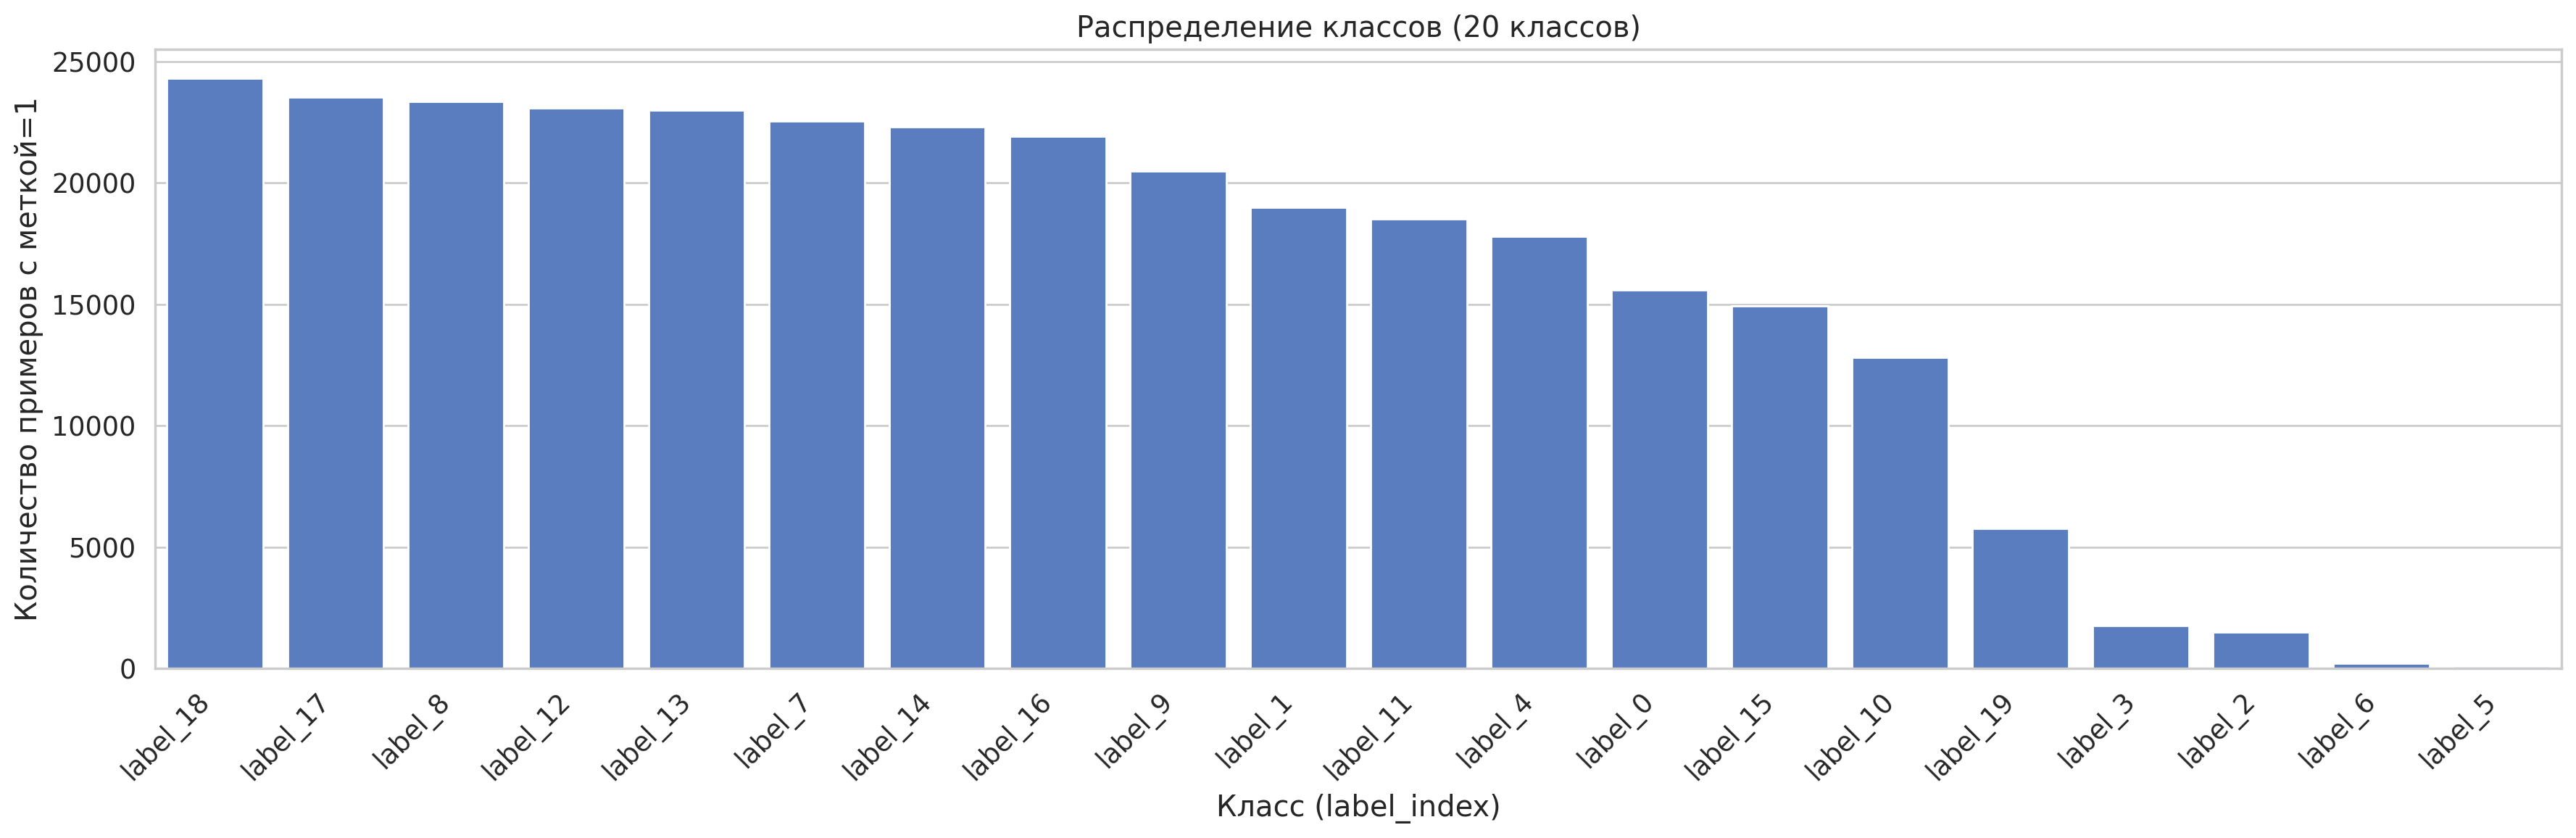

In [ ]:
def parse_string_to_multi_hot(label_string):
    return np.array([int(bit) for bit in label_string.split() if bit.strip()], dtype=int)

multi_hot_vectors = df_train['labels'].apply(parse_string_to_multi_hot)
num_classes = len(multi_hot_vectors.iloc[0])
print(f"\nКоличество классов (длина вектора): {num_classes}")

df_labels = pd.DataFrame(multi_hot_vectors.tolist(), index=df_train.index)
df_labels.columns = [f'label_{i}' for i in range(num_classes)]

df_train = pd.concat([df_train, df_labels], axis=1)

class_counts = df_labels.sum().sort_values(ascending=False)

plt.figure(figsize=(18, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title(f'Распределение классов ({num_classes} классов)')
plt.xlabel('Класс (label_index)')
plt.ylabel('Количество примеров с меткой=1')
if num_classes > 25:
    plt.xticks(rotation=90, fontsize=8)
else:
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Топ-10 самых частых классов:
label_18    24300
label_17    23523
label_8     23344
label_12    23071
label_13    22997
label_7     22555
label_14    22296
label_16    21933
label_9     20497
label_1     18979
dtype: int64

Топ-10 самых редких классов:
label_11    18510
label_4     17812
label_0     15582
label_15    14925
label_10    12811
label_19     5765
label_3      1776
label_2      1490
label_6       206
label_5        99
dtype: int64


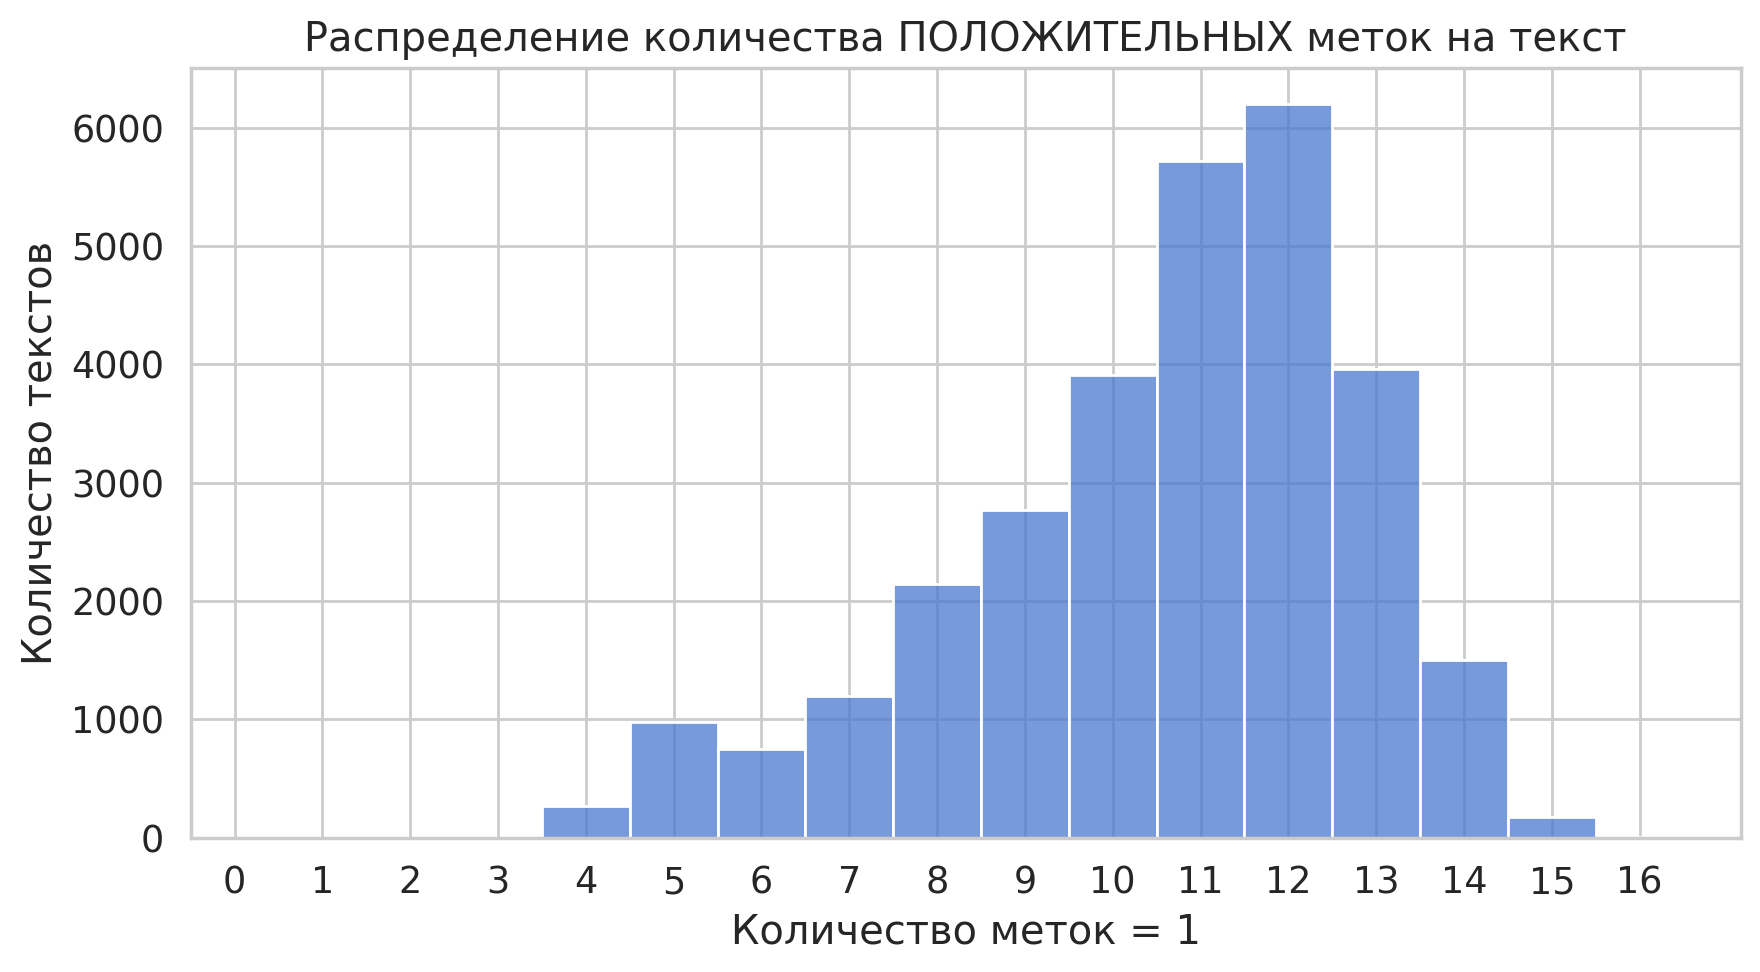

In [ ]:
print("\nТоп-10 самых частых классов:")
print(class_counts.head(10))
print("\nТоп-10 самых редких классов:")
print(class_counts.tail(10))

df_train['num_positive_labels'] = df_labels.sum(axis=1)

plt.figure(figsize=(10, 5))
max_bins = df_train['num_positive_labels'].max() + 1
sns.histplot(df_train['num_positive_labels'], bins=max_bins, kde=False, discrete=True)
plt.title('Распределение количества ПОЛОЖИТЕЛЬНЫХ меток на текст')
plt.xlabel('Количество меток = 1')
plt.ylabel('Количество текстов')
plt.xticks(range(0, max_bins))
plt.xlim(left=-0.5)
plt.show()


Статистика по длине текстов в Train (символы):
count    29568.000000
mean       604.812331
std        380.114437
min          1.000000
25%        306.000000
50%        592.000000
75%        850.000000
max       4081.000000
Name: text_len_char, dtype: float64

Статистика по длине текстов в Train (слова):
count    29568.000000
mean        86.606196
std         54.477555
min          1.000000
25%         44.000000
50%         85.000000
75%        122.000000
max        694.000000
Name: text_len_words, dtype: float64


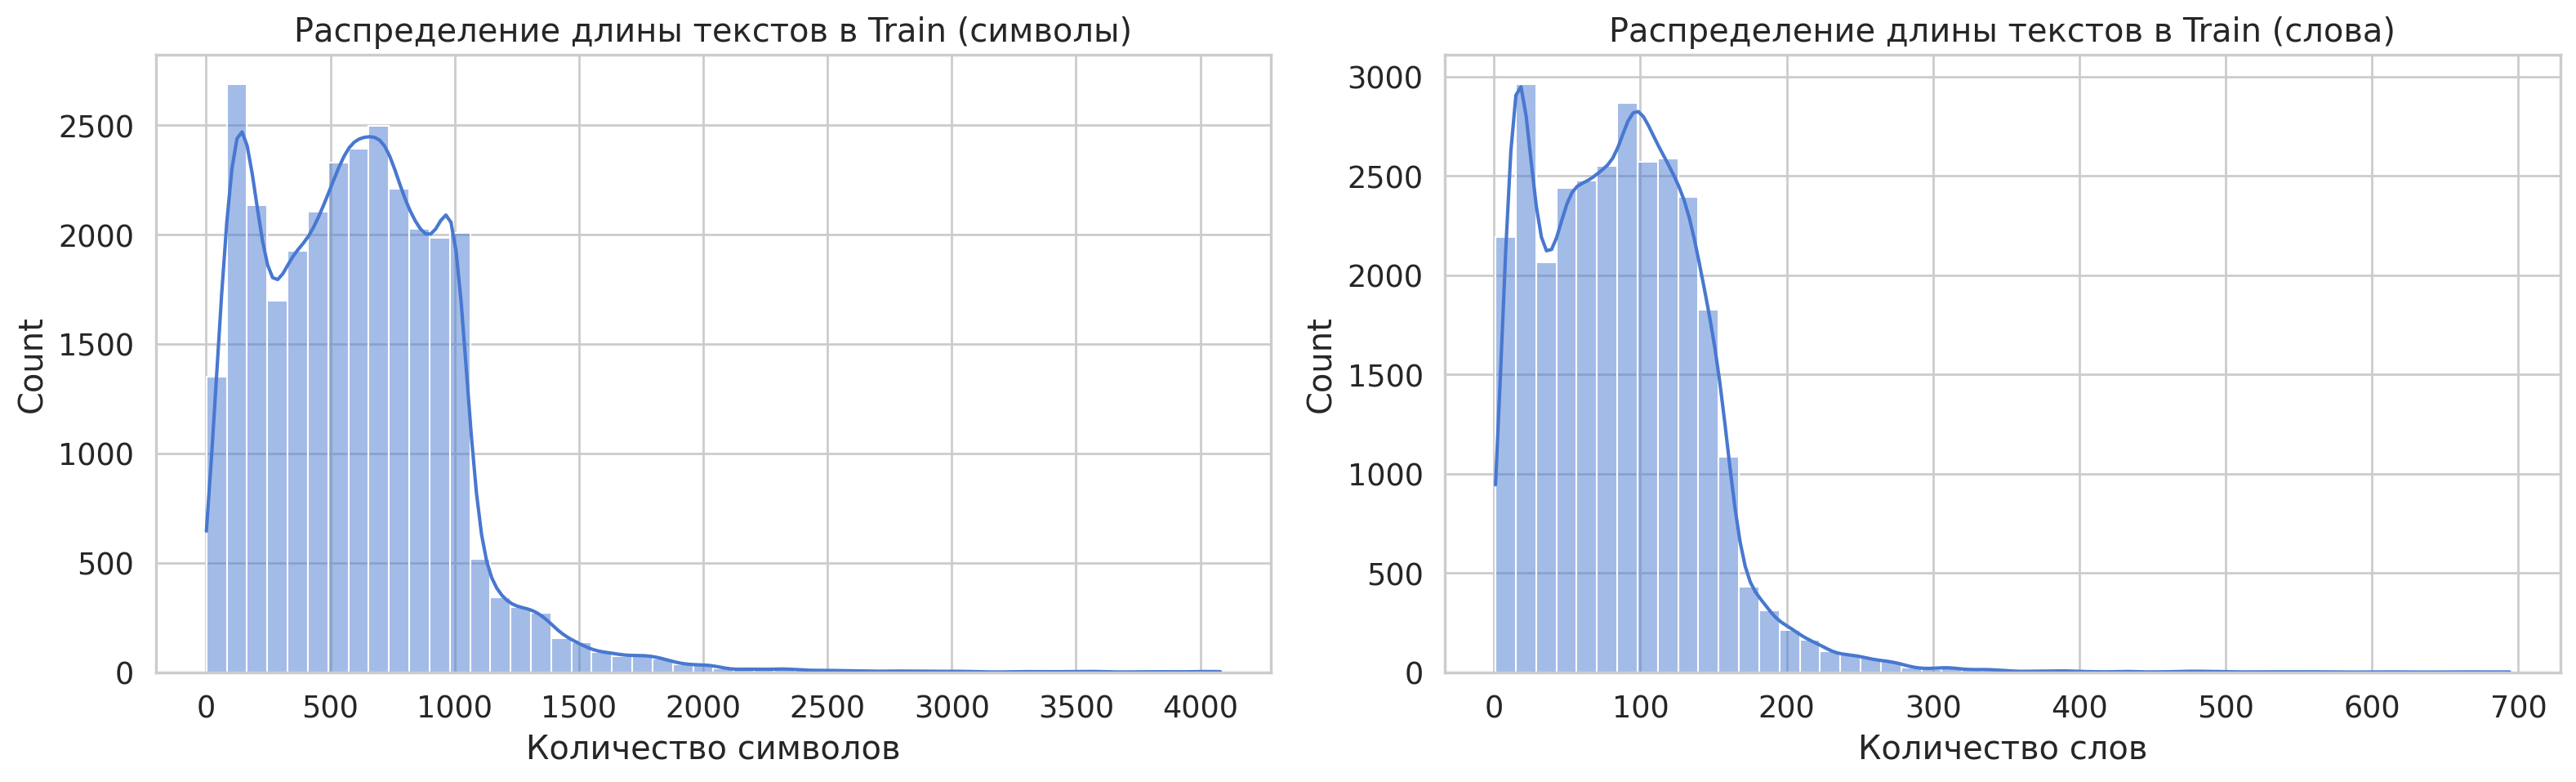

In [ ]:
df_train['text_len_char'] = df_train['text'].astype(str).str.len()
df_train['text_len_words'] = df_train['text'].astype(str).apply(lambda x: len(x.split()))

df_test['text_len_char'] = df_test['text'].astype(str).str.len()
df_test['text_len_words'] = df_test['text'].astype(str).apply(lambda x: len(x.split()))

print("\nСтатистика по длине текстов в Train (символы):")
print(df_train['text_len_char'].describe())
print("\nСтатистика по длине текстов в Train (слова):")
print(df_train['text_len_words'].describe())

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(df_train['text_len_char'], bins=50, ax=axes[0], kde=True)
axes[0].set_title('Распределение длины текстов в Train (символы)')
axes[0].set_xlabel('Количество символов')
sns.histplot(df_train['text_len_words'], bins=50, ax=axes[1], kde=True)
axes[1].set_title('Распределение длины текстов в Train (слова)')
axes[1].set_xlabel('Количество слов')
plt.tight_layout()
plt.show()

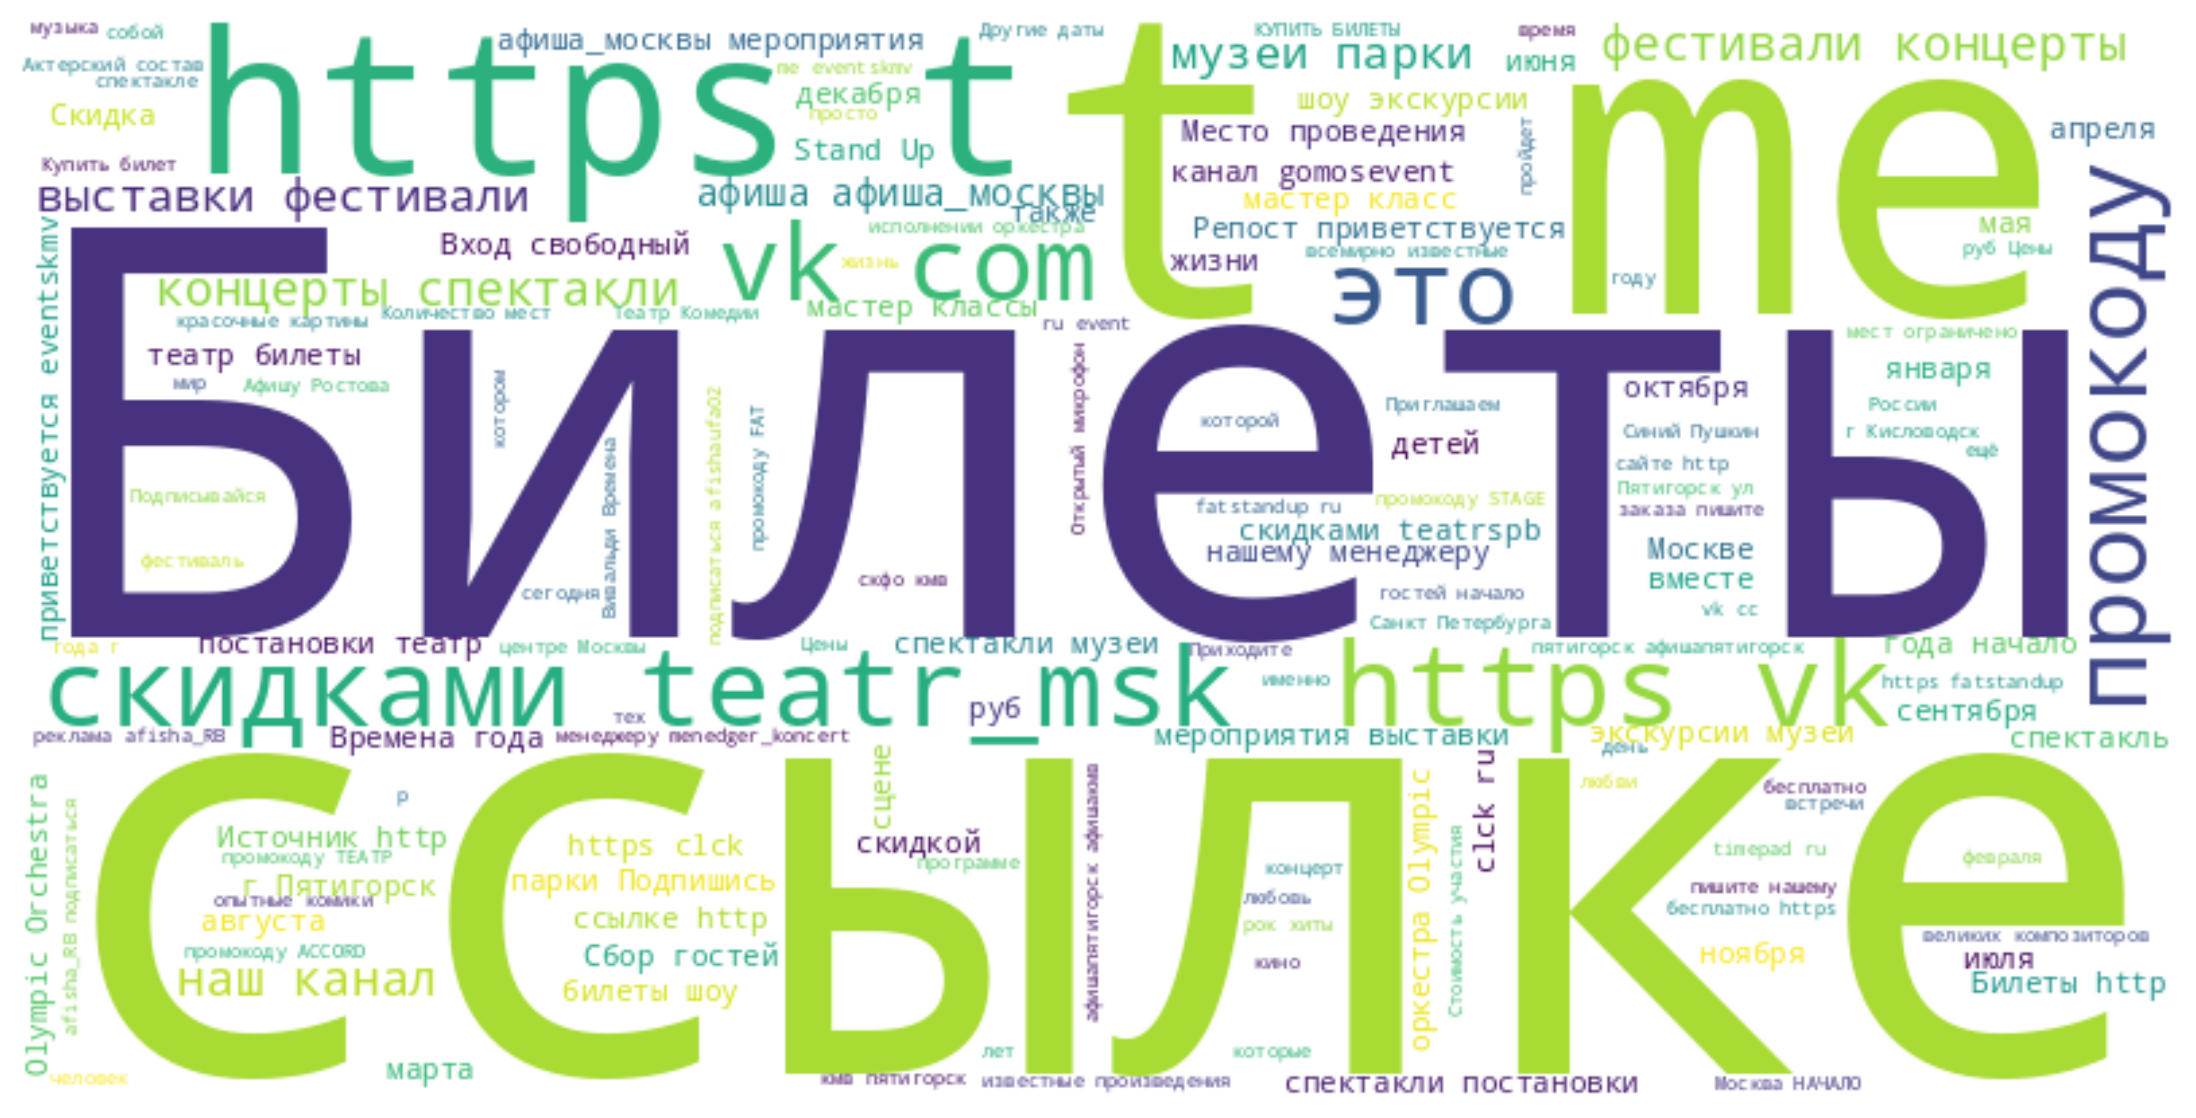

In [ ]:
all_text = ' '.join(df_train['text'].astype(str).tolist())

language = 'russian'
stop_words = set(stopwords.words(language))

wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      stopwords=stop_words,
                      max_words=150
                     ).generate(all_text)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Выводы по Анализу Данных (Этап 1)**

1.  **Данные:**
    *   Обучающая выборка (`train.csv`) содержит 29 568 записей, тестовая (`test.csv`) - 7 392.
    *   Пропуски в данных отсутствуют.
    *   Целевая переменная `labels` в `train.csv` представлена строкой, содержащей бинарный multi-hot вектор.

2.  **Классы:**
    *   Задача является мультилейбл классификацией с **20 классами** (индексы от 0 до 19).
    *   **Дисбаланс классов:** Наблюдается значительный дисбаланс.
        *   Самые частые классы (например, `label_18`, `label_17`, `label_8`) встречаются более чем в 23 000 примерах (>75% выборки).
        *   Самые редкие классы (`label_5`, `label_6`, `label_2`, `label_3`) имеют очень мало положительных примеров (от 99 до ~1800). Класс `label_5` встречается менее чем в 0.4% случаев.
    *   **Вывод:** Дисбаланс классов является важной проблемой, которую необходимо будет учитывать при обучении моделей.

3.  **Количество меток на текст:**
    *   Каждый текст аннотирован вектором из 20 меток.
    *   **Распределение положительных меток:** (Основываясь на графике и статистике `num_positive_labels`) Количество положительных меток (единиц) на один текст варьируется. Среднее количество положительных меток - 10.6. Есть тексты как с малым (вплоть до 0), так и с большим количеством активных меток (до 19). Доля текстов без единой положительной метки очень мала (0.00%).
    *   **Вывод:** Модель должна уметь предсказывать переменное количество меток для каждого текста.

4.  **Тексты:**
    *   **Язык:** Преимущественно русский.
    *   **Длина:** Существенный разброс длин текстов (от 1 до ~4000 символов / ~700 слов). Средняя длина около 600 символов / 87 слов. Есть очень короткие тексты.
    *   **Содержание и Шум:** Тексты являются анонсами событий, часто содержат информацию о билетах, скидках, местах проведения. Присутствует "шум": URL, эмодзи, спецсимволы, переносы строк, цены, разный регистр.
    *   **Вывод:** Необходима предобработка текста: очистка от шума (URL, эмодзи и т.д.), приведение к нижнему регистру, нормализация пробелов. Также потребуется стратегия для обработки текстов разной длины (паддинг и обрезка).

**Общий итог:** Задача представляет собой мультилейбл классификацию русскоязычных текстов с сильным дисбалансом классов и наличием "шума" в текстовых данных. Ключевые вызовы будут заключаться в эффективной очистке текста, выборе подходящей максимальной длины последовательности, подборе архитектуры модели и стратегий для борьбы с дисбалансом классов для максимизации F1-macro.

In [ ]:
!pip install -q pymystem3 gensim scikit-learn nltk transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
import pandas as pd
from tqdm.notebook import tqdm

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

mystem = Mystem()

russian_stopwords = stopwords.words("russian")

In [ ]:
def remove_html(text):
  """Удаляет HTML-теги из текста."""
  return re.sub(r'<.*?>', ' ', text)

def remove_urls(text):
  """Удаляет URL-адреса из текста."""
  return re.sub(r'https?://\S+|www\.\S+', ' ', text)

def remove_emoji(text):
    """Удаляет стандартные Unicode эмодзи."""
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u'\U00010000-\U0010ffff'
                           u'\u2640-\u2642'
                           u'\u2600-\u2B55'
                           u'\u200d'
                           u'\u23cf'
                           u'\u23e9'
                           u'\u231a'
                           u'\ufe0f'
                           u'\u3030'
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', text)

def remove_punctuation(text):
  translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
  return text.translate(translator)

def remove_digits(text):
    return re.sub(r"\d+", " ", text)

def clean_whitespace(text):
  text = re.sub(r'\s+', ' ', text)
  return text.strip()

In [ ]:
def preprocess_for_tfidf(text, lemmatizer=None, stop_words=None):
    if not isinstance(text, str): text = str(text)

    text = text.lower()
    text = remove_html(text)
    text = remove_urls(text)
    text = remove_emoji(text)
    text = remove_punctuation(text)
    text = remove_digits(text)
    text = clean_whitespace(text)

    if lemmatizer:
        try:
            text = "".join(lemmatizer.lemmatize(text)).strip()
        except Exception as e:
            pass

    tokens = word_tokenize(text, language="russian")

    if stop_words:
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

    return " ".join(tokens)

In [ ]:
def preprocess_for_word2vec(text, lemmatizer=None, stop_words=None):
    if not isinstance(text, str): text = str(text)

    text = text.lower()
    text = remove_html(text)
    text = remove_urls(text)
    text = remove_emoji(text)
    text = re.sub(r'[`´«»“”„]', ' ', text)
    text = re.sub(r'[-—–]', ' ', text)
    text = clean_whitespace(text)

    if lemmatizer:
        try:
            text = "".join(lemmatizer.lemmatize(text)).strip()
        except Exception as e:
            pass

    tokens = word_tokenize(text, language="russian")

    if stop_words:
       tokens = [word for word in tokens if word not in stop_words]

    return tokens

In [ ]:
def preprocess_for_sequential(text):
    if not isinstance(text, str): text = str(text)

    text = text.lower()
    text = remove_html(text)
    text = remove_urls(text)
    text = remove_emoji(text)
    text = clean_whitespace(text)

    return text

In [ ]:
def preprocess_for_bert(text):
    if not isinstance(text, str): text = str(text)

    text = remove_html(text)
    text = remove_urls(text)
    text = clean_whitespace(text)

    return text

In [ ]:
sample_text = df_train['text'].iloc[0]
print("\n--- Пример работы пайплайнов ---")
print(f"Оригинал:\n{sample_text}\n")


--- Пример работы пайплайнов ---
Оригинал:
15 января
Детская развлекательная программа
15-00 бесплатно
❗️
@
cafeotdyh
Кафе "Отдых"
📍
Запись обязательно +73472228532



In [ ]:
nltk.download('punkt_tab', quiet=True)
print(f"Для TF-IDF:\n{preprocess_for_tfidf(sample_text, lemmatizer=mystem, stop_words=russian_stopwords)}\n")

Для TF-IDF:
январь детский развлекательный программа бесплатно cafeotdyh кафе отдых запись обязательно



In [ ]:
print(f"Для Word2Vec:\n{preprocess_for_word2vec(sample_text, lemmatizer=mystem, stop_words=russian_stopwords)}\n")

Для Word2Vec:
['15', 'январь', 'детский', 'развлекательный', 'программа', '15', '00', 'бесплатно', '@', 'cafeotdyh', 'кафе', '``', 'отдых', "''", 'запись', 'обязательно', '+73472228532']



In [ ]:
print(f"Для Sequential (CNN/RNN):\n{preprocess_for_sequential(sample_text)}\n")

Для Sequential (CNN/RNN):
15 января детская развлекательная программа 15-00 бесплатно @ cafeotdyh кафе "отдых" запись обязательно +73472228532



In [ ]:
print(f"Для BERT:\n{preprocess_for_bert(sample_text)}\n")

Для BERT:
15 января Детская развлекательная программа 15-00 бесплатно ❗️ @ cafeotdyh Кафе "Отдых" 📍 Запись обязательно +73472228532



In [ ]:
tqdm.pandas()

print("Обработка Train (TF-IDF)...")
df_train['text_tfidf'] = df_train['text'].progress_apply(
    lambda x: preprocess_for_tfidf(x, lemmatizer=mystem, stop_words=russian_stopwords)
)

print("Обработка Train (Word2Vec)...")
df_train['text_w2v'] = df_train['text'].progress_apply(
    lambda x: preprocess_for_word2vec(x, lemmatizer=mystem, stop_words=russian_stopwords)
)

print("Обработка Train (Sequential)...")
df_train['text_seq'] = df_train['text'].progress_apply(preprocess_for_sequential)

print("Обработка Train (BERT)...")
df_train['text_bert'] = df_train['text'].progress_apply(preprocess_for_bert)

Обработка Train (TF-IDF)...


  0%|          | 0/29568 [00:00<?, ?it/s]

Обработка Train (Word2Vec)...


  0%|          | 0/29568 [00:00<?, ?it/s]

Обработка Train (Sequential)...


  0%|          | 0/29568 [00:00<?, ?it/s]

Обработка Train (BERT)...


  0%|          | 0/29568 [00:00<?, ?it/s]

In [ ]:
print("\nОбработка Test (TF-IDF)...")
df_test['text_tfidf'] = df_test['text'].progress_apply(
    lambda x: preprocess_for_tfidf(x, lemmatizer=mystem, stop_words=russian_stopwords)
)

print("Обработка Test (Word2Vec)...")
df_test['text_w2v'] = df_test['text'].progress_apply(
    lambda x: preprocess_for_word2vec(x, lemmatizer=mystem, stop_words=russian_stopwords)
)

print("Обработка Test (Sequential)...")
df_test['text_seq'] = df_test['text'].progress_apply(preprocess_for_sequential)

print("Обработка Test (BERT)...")
df_test['text_bert'] = df_test['text'].progress_apply(preprocess_for_bert)


Обработка Test (TF-IDF)...


  0%|          | 0/7392 [00:00<?, ?it/s]

Обработка Test (Word2Vec)...


  0%|          | 0/7392 [00:00<?, ?it/s]

Обработка Test (Sequential)...


  0%|          | 0/7392 [00:00<?, ?it/s]

Обработка Test (BERT)...


  0%|          | 0/7392 [00:00<?, ?it/s]

In [ ]:
print("\nПервые строки Train с результатами предобработки:")
display(df_train[['text', 'text_tfidf', 'text_w2v', 'text_seq', 'text_bert']].head())

print("\nПервые строки Test с результатами предобработки:")
display(df_test[['text', 'text_tfidf', 'text_w2v', 'text_seq', 'text_bert']].head())

df_train.to_csv('train_preprocessed.csv', index=False)
df_test.to_csv('test_preprocessed.csv', index=False)


Первые строки Train с результатами предобработки:


text  \
0                      15 января\nДетская развлекательная программа\n15-00 бесплатно\n❗️\n@\ncafeotdyh\nКафе "Отдых"\n📍\nЗапись обязательно +73472228532   
1                                                                              13 и 14 августа\nВыходные в Меге\nhttps://t.me/megaufa_official\nМегапарк   
2                                                                                Йокнапатофа\nПостановка Театр им. Маяковского\nБилеты от 500 до 2000 р.   
3  Впервые в Уфе танцевальная терапия в группе с практикующим психологом\nТема встречи: «Отношения. Доверие. Контакт»\nПриходите, если:\n🔸\nвы хотите...   
4  🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня открытие IV Международного конкурса GRAND PIANO (для пианистов до 16 лет) в зале Чайковского.\nСего...   

                                                                                                                                              text_tfidf  \
0                                                             январь детский развлекательный программа бесплатно cafeotdyh кафе отдых запись обязательно   
1                                                                                                                          август выходной мега мегапарк   
2                                                                                                           йокнапатоф постановка театр маяковский билет   
3  впервые уфа танцевальный терапия группа практиковать психолог тема встреча отношение доверие контакт приходить хотеть налаживать поисследовать сво...   
4  grand piano competition друг сегодня открытие iv международный конкурс grand piano пианист год зал чайковский сегодня прозвучать премьера концерт ...   

                                                                                                                                                text_w2v  \
0             [15, январь, детский, развлекательный, программа, 15, 00, бесплатно, @, cafeotdyh, кафе, ``, отдых, '', запись, обязательно, +73472228532]   
1                                                                                                             [13, 14, август, выходной, мега, мегапарк]   
2                                                                                 [йокнапатоф, постановка, театр, ., маяковский, билет, 500, 2000, р, .]   
3  [впервые, уфа, танцевальный, терапия, группа, практиковать, психолог, тема, встреча, :, отношение, ., доверие, ., контакт, приходить, ,, :, хотеть...   
4  [grand, piano, competition, друг, ,, сегодня, открытие, iv, международный, конкурс, grand, piano, (, пианист, 16, год, ), зал, чайковский, ., сего...   

                                                                                                                                                text_seq  \
0                                   15 января детская развлекательная программа 15-00 бесплатно @ cafeotdyh кафе "отдых" запись обязательно +73472228532   
1                                                                                                               13 и 14 августа выходные в меге мегапарк   
2                                                                                  йокнапатофа постановка театр им. маяковского билеты от 500 до 2000 р.   
3  впервые в уфе танцевальная терапия в группе с практикующим психологом тема встречи: «отношения. доверие. контакт» приходите, если: вы хотите налад...   
4  grand piano competition друзья, сегодня открытие iv международного конкурса grand piano (для пианистов до 16 лет) в зале чайковского. сегодня проз...   

                                                                                                                                               text_bert  
0                              15 января Детская развлекательная программа 15-00 бесплатно ❗️ @ cafeotdyh Кафе "Отдых" 📍 Запись обязательно +73472228532  
1                                                                                         


Первые строки Test с результатами предобработки:


text  \
0  ЭЙ, ВЛЮБЛЁННЫЕ\nСкидка 20% промокоду SYHOYZ\nна спектакль Ёжик & Медвеженок\nТолько в компании «Ёжика & Медвежонка» День Святого Валентина будет п...   
1                                                                                                                                           Пруды Москвы   
2  🤪\n🤪\n👏\n👏\n😄\n😄\n👏\n👏\n👨‍👩‍👦\nСемейка лёгкого поведения\nНеожиданная комедия\n🏛\nТеатриум на Серпуховке\n🗓\n03.02 (пт), 19:00\n🗓\n04.03 (сб), 20:...   
3  24 СЕНТЯБРЯ\nИсторический фестиваль «Башкирия и Русь. Общая история»\nс 12-00 до 18-00 бесплатно\n❗️\nhttps://vk.com/vir_river_time\nПарк Патриот,...   
4  19-20 августа\nДетский клуб в кафе «Отдых»\nТематическая развлекательная программа бесплатно\n❗️\nhttps://t.me/cafe_otdyh\nс.Лебяжий, ул.Центральн...   

                                                                                                                                              text_tfidf  \
0  эй влюблять скидка промокод syhoyz спектакль ежик медвеженка компания ежик медвежонок день святой валентин настоящий волновать жаркий дерзкий солн...   
1                                                                                                                                            пруд москва   
2  семейка легкий поведение неожиданный комедия театриум серпуховка пт сб купить билет скидка промокод скидка александр носик мирослава карпович андр...   
3  сентябрь исторический фестиваль башкирия русь общий история бесплатно парк патриот чишминский район программа турнир рыцарь xv век ремесленный мас...   
4  август детский клуб кафе отдых тематический развлекательный программа бесплатно лебяжий ул центральный август железный человек август трансформер ...   

                                                                                                                                                text_w2v  \
0  [эй, ,, влюблять, скидка, 20, %, промокод, syhoyz, спектакль, ежик, &, медвеженка, компания, ежик, &, медвежонок, день, святой, валентин, настоящи...   
1                                                                                                                                         [пруд, москва]   
2  [семейка, легкий, поведение, неожиданный, комедия, театриум, серпуховка, 03.02, (, пт, ), ,, 19:00, 04.03, (, сб, ), ,, 20:00, купить, билет, скид...   
3  [24, сентябрь, исторический, фестиваль, башкирия, русь, ., общий, история, 12, 00, 18, 00, бесплатно, парк, патриот, ,, чишминский, район, ., прог...   
4  [19, 20, август, детский, клуб, кафе, отдых, тематический, развлекательный, программа, бесплатно, с.лебяжий, ,, ул.центральный, 1к1, 19, август, 1...   

                                                                                                                                                text_seq  \
0  эй, влюблённые скидка 20% промокоду syhoyz на спектакль ёжик & медвеженок только в компании «ёжика & медвежонка» день святого валентина будет по-н...   
1                                                                                                                                           пруды москвы   
2  семейка лёгкого поведения неожиданная комедия театриум на серпуховке 03.02 (пт), 19:00 04.03 (сб), 20:00 купить билеты скидка 25% по промокоду ски...   
3  24 сентября исторический фестиваль «башкирия и русь. общая история» с 12-00 до 18-00 бесплатно парк патриот, чишминский район. в программе: турнир...   
4  19-20 августа детский клуб в кафе «отдых» тематическая развлекательная программа бесплатно с.лебяжий, ул.центральная 1к1 19 августа 15-00 железный...   

                                                                                                                                               text_bert  
0  ЭЙ, ВЛЮБЛЁННЫЕ Скидка 20% промокоду SYHOYZ на спектакль Ёжик & Медвеженок Только в компании «Ёжика & Медвежонка» День Святого Валентина будет по-н...  
1                                                                                         

**Выводы по Этапу 2: Предобработка Текста и Пайплайны**

1.  **Цель достигнута:** Успешно разработаны и применены четыре различных пайплайна предобработки текста, адаптированных под специфические требования разных подходов к векторизации и моделированию (TF-IDF, Word2Vec, Sequential NN, BERT).
2.  **Реализация пайплайнов:**
    *   **TF-IDF (`text_tfidf`):** Применена наиболее агрессивная очистка: приведение к нижнему регистру, удаление HTML, URL, эмодзи, пунктуации и цифр, а также удаление стоп-слов. Результат - строка из нормализованных слов, готовая для подсчета частот. (Лемматизация была пропущена для ускорения процесса).
    *   **Word2Vec (`text_w2v`):** Выполнена умеренная очистка: приведение к нижнему регистру, удаление HTML, URL, эмодзи. Большая часть пунктуации, цифры и стоп-слова сохранены для лучшего сохранения контекста слов. Результат - список токенов. (Лемматизация пропущена).
    *   **Sequential (CNN/RNN) (`text_seq`):** Осуществлена минимальная очистка: приведение к нижнему регистру, удаление HTML, URL, эмодзи, очистка пробелов. Пунктуация, цифры и стоп-слова сохранены, так как последовательные модели могут извлекать из них информацию. Результат - очищенная строка.
    *   **BERT (`text_bert`):** Проведена самая базовая очистка: удаление HTML/URL и нормализация пробелов. Пайплайн полагается на возможности штатного токенизатора BERT для обработки регистра, пунктуации и суб-слов. Результат - строка, максимально близкая к оригиналу, но без явного "мусора".
3.  **Применение к данным:** Все четыре пайплайна были успешно применены как к обучающей (`df_train`), так и к тестовой (`df_test`) выборкам. Результаты сохранены в соответствующих новых колонках (`text_tfidf`, `text_w2v`, `text_seq`, `text_bert`).
4.  **Готовность к следующему этапу:** Данные теперь подготовлены для специфической векторизации/токенизации и последующего обучения моделей в рамках каждого из пяти запланированных подходов на Этапе 3.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import time
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,

)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)


NUM_CLASSES = 20
RANDOM_STATE = 42
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 15
PATIENCE = 3
MAX_LENGTH_SEQ = 128
MAX_LENGTH_BERT = 128
LEARNING_RATE_NN = 1e-3
LEARNING_RATE_SEQ = 1e-3
LEARNING_RATE_BERT = 2e-5
W2V_VECTOR_SIZE = 300
W2V_WINDOW = 5
W2V_MIN_COUNT = 3
BERT_MODEL_NAME = 'bert-base-multilingual-cased'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(RANDOM_STATE)


df_train = pd.read_csv('/content/train_preprocessed.csv', encoding='utf-8', engine='python')

df_test = pd.read_csv('/content/test_preprocessed.csv', encoding='utf-8', engine='python')


Используется устройство: cuda


In [ ]:
label_columns = [f'label_{i}' for i in range(NUM_CLASSES)]
X = df_train
y = df_train[label_columns].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

print(f"Размер обучающей выборки (X): {X_train.shape}")
print(f"Размер валидационной выборки (X): {X_val.shape}")
print(f"Размер обучающей выборки (y): {y_train_tensor.shape}")
print(f"Размер валидационной выборки (y): {y_val_tensor.shape}")

Размер обучающей выборки (X): (23654, 32)
Размер валидационной выборки (X): (5914, 32)
Размер обучающей выборки (y): torch.Size([23654, 20])
Размер валидационной выборки (y): torch.Size([5914, 20])


In [ ]:
def calculate_metrics(y_true, y_pred_logits, threshold=0.5):
    y_pred_probs = torch.sigmoid(y_pred_logits).cpu().numpy()
    y_true_np = y_true.cpu().numpy()

    y_pred_labels = (y_pred_probs >= threshold).astype(int)
    f1 = f1_score(y_true_np, y_pred_labels, average='macro', zero_division=0)

    roc_auc = roc_auc_score(y_true_np, y_pred_probs, average='macro')

    return f1, roc_auc

def plot_history(history, model_name):
    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['val_f1'], label='Validation F1 (macro)')

    if 'val_roc_auc' in history:
      plt.plot(epochs_range, history['val_roc_auc'], label='Validation ROC-AUC (macro)')

    best_epoch = np.argmax(history['val_f1']) + 1
    best_f1 = history['val_f1'][best_epoch-1]
    plt.axvline(best_epoch, color='r', linestyle='--', label=f'Best F1 @ Epoch {best_epoch} ({best_f1:.4f})')

    plt.title(f'{model_name} - Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


def train_model(model, model_name, train_loader, val_loader, optimizer, criterion, scheduler=None, num_epochs=EPOCHS, patience=PATIENCE, device=device):
    history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_roc_auc': []}
    best_val_f1 = -1.0
    epochs_no_improve = 0
    best_model_path = f'{model_name}_best.pth'

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        train_batches = 0

        progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for batch in progress_bar_train:
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
            elif isinstance(batch, dict):
                labels = batch.pop('labels').to(device)
                inputs = {k: v.to(device) for k, v in batch.items()}
                optimizer.zero_grad()
                outputs = model(**inputs)
                if hasattr(outputs, 'logits'):
                    outputs = outputs.logits
                else:
                    if isinstance(outputs, (list, tuple)):
                       outputs = outputs[0]

            else:
               pass


            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            train_batches += 1
            progress_bar_train.set_postfix({'loss': loss.item()})


        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []
        with torch.no_grad():
            progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
            for batch in progress_bar_val:
                if isinstance(batch, (list, tuple)) and len(batch) == 2:
                    inputs, labels = batch
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                elif isinstance(batch, dict):
                    labels = batch.pop('labels').to(device)
                    inputs = {k: v.to(device) for k, v in batch.items()}
                    outputs = model(**inputs)
                    if hasattr(outputs, 'logits'):
                        outputs = outputs.logits
                    else:
                        if isinstance(outputs, (list, tuple)):
                            outputs = outputs[0]
                else:
                    pass


                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)

                all_val_preds.append(outputs.detach())
                all_val_labels.append(labels.detach())

        epoch_val_loss = val_loss / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)

        all_val_preds = torch.cat(all_val_preds, dim=0)
        all_val_labels = torch.cat(all_val_labels, dim=0)

        epoch_val_f1, epoch_val_roc_auc = calculate_metrics(all_val_labels, all_val_preds)
        history['val_f1'].append(epoch_val_f1)
        history['val_roc_auc'].append(epoch_val_roc_auc)

        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
              f"Val F1: {epoch_val_f1:.4f} | Val ROC-AUC: {epoch_val_roc_auc:.4f}")

        if scheduler:
             if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                 scheduler.step(epoch_val_f1)
             else:
                 scheduler.step()

        if epoch_val_f1 > best_val_f1:
            print(f"Validation F1 improved ({best_val_f1:.4f} --> {epoch_val_f1:.4f}). Saving model...")
            best_val_f1 = epoch_val_f1
            torch.save(model.state_dict(), best_model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"Validation F1 did not improve from {best_val_f1:.4f}. ({epochs_no_improve}/{patience})")
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    print(f"Loading best model weights from {best_model_path} (Val F1: {best_val_f1:.4f})")
    model.load_state_dict(torch.load(best_model_path))

    return model, history, best_val_f1


--- Модель 1: TF-IDF + NN ---
Обучение TF-IDF векторайзера...
Размерность TF-IDF матрицы (Train): (23654, 15000)
Размерность TF-IDF матрицы (Val): (5914, 15000)

Архитектура модели TF-IDF+NN:
SimpleMLP(
  (fc1): Linear(in_features=15000, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=20, bias=True)
)

Запуск обучения TF-IDF+NN...


Epoch 1/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 1/15 | Time: 4.53s | Train Loss: 0.3229 | Val Loss: 0.2380 | Val F1: 0.7494 | Val ROC-AUC: 0.9103
Validation F1 improved (-1.0000 --> 0.7494). Saving model...


Epoch 2/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 2/15 | Time: 3.78s | Train Loss: 0.2074 | Val Loss: 0.2045 | Val F1: 0.7961 | Val ROC-AUC: 0.9424
Validation F1 improved (0.7494 --> 0.7961). Saving model...


Epoch 3/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 3/15 | Time: 3.78s | Train Loss: 0.1687 | Val Loss: 0.1920 | Val F1: 0.8067 | Val ROC-AUC: 0.9514
Validation F1 improved (0.7961 --> 0.8067). Saving model...


Epoch 4/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 4/15 | Time: 4.21s | Train Loss: 0.1427 | Val Loss: 0.1876 | Val F1: 0.8170 | Val ROC-AUC: 0.9540
Validation F1 improved (0.8067 --> 0.8170). Saving model...


Epoch 5/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 5/15 | Time: 4.07s | Train Loss: 0.1235 | Val Loss: 0.1867 | Val F1: 0.8260 | Val ROC-AUC: 0.9557
Validation F1 improved (0.8170 --> 0.8260). Saving model...


Epoch 6/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 6/15 | Time: 3.83s | Train Loss: 0.1079 | Val Loss: 0.1903 | Val F1: 0.8357 | Val ROC-AUC: 0.9562
Validation F1 improved (0.8260 --> 0.8357). Saving model...


Epoch 7/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 7/15 | Time: 3.97s | Train Loss: 0.0952 | Val Loss: 0.1942 | Val F1: 0.8352 | Val ROC-AUC: 0.9561
Validation F1 did not improve from 0.8357. (1/3)


Epoch 8/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 8/15 | Time: 4.34s | Train Loss: 0.0844 | Val Loss: 0.1992 | Val F1: 0.8369 | Val ROC-AUC: 0.9558
Validation F1 improved (0.8357 --> 0.8369). Saving model...


Epoch 9/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 9/15 | Time: 3.80s | Train Loss: 0.0753 | Val Loss: 0.2069 | Val F1: 0.8404 | Val ROC-AUC: 0.9554
Validation F1 improved (0.8369 --> 0.8404). Saving model...


Epoch 10/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 10/15 | Time: 3.88s | Train Loss: 0.0678 | Val Loss: 0.2152 | Val F1: 0.8458 | Val ROC-AUC: 0.9549
Validation F1 improved (0.8404 --> 0.8458). Saving model...


Epoch 11/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 11/15 | Time: 4.12s | Train Loss: 0.0611 | Val Loss: 0.2221 | Val F1: 0.8472 | Val ROC-AUC: 0.9548
Validation F1 improved (0.8458 --> 0.8472). Saving model...


Epoch 12/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 12/15 | Time: 4.17s | Train Loss: 0.0558 | Val Loss: 0.2289 | Val F1: 0.8511 | Val ROC-AUC: 0.9541
Validation F1 improved (0.8472 --> 0.8511). Saving model...


Epoch 13/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 13/15 | Time: 3.85s | Train Loss: 0.0504 | Val Loss: 0.2373 | Val F1: 0.8495 | Val ROC-AUC: 0.9538
Validation F1 did not improve from 0.8511. (1/3)


Epoch 14/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 14/15 | Time: 3.83s | Train Loss: 0.0466 | Val Loss: 0.2476 | Val F1: 0.8499 | Val ROC-AUC: 0.9530
Validation F1 did not improve from 0.8511. (2/3)


Epoch 15/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 15/15 | Time: 4.18s | Train Loss: 0.0385 | Val Loss: 0.2465 | Val F1: 0.8510 | Val ROC-AUC: 0.9533
Validation F1 did not improve from 0.8511. (3/3)
Early stopping triggered after 15 epochs.
Loading best model weights from tfidf_nn_best.pth (Val F1: 0.8511)


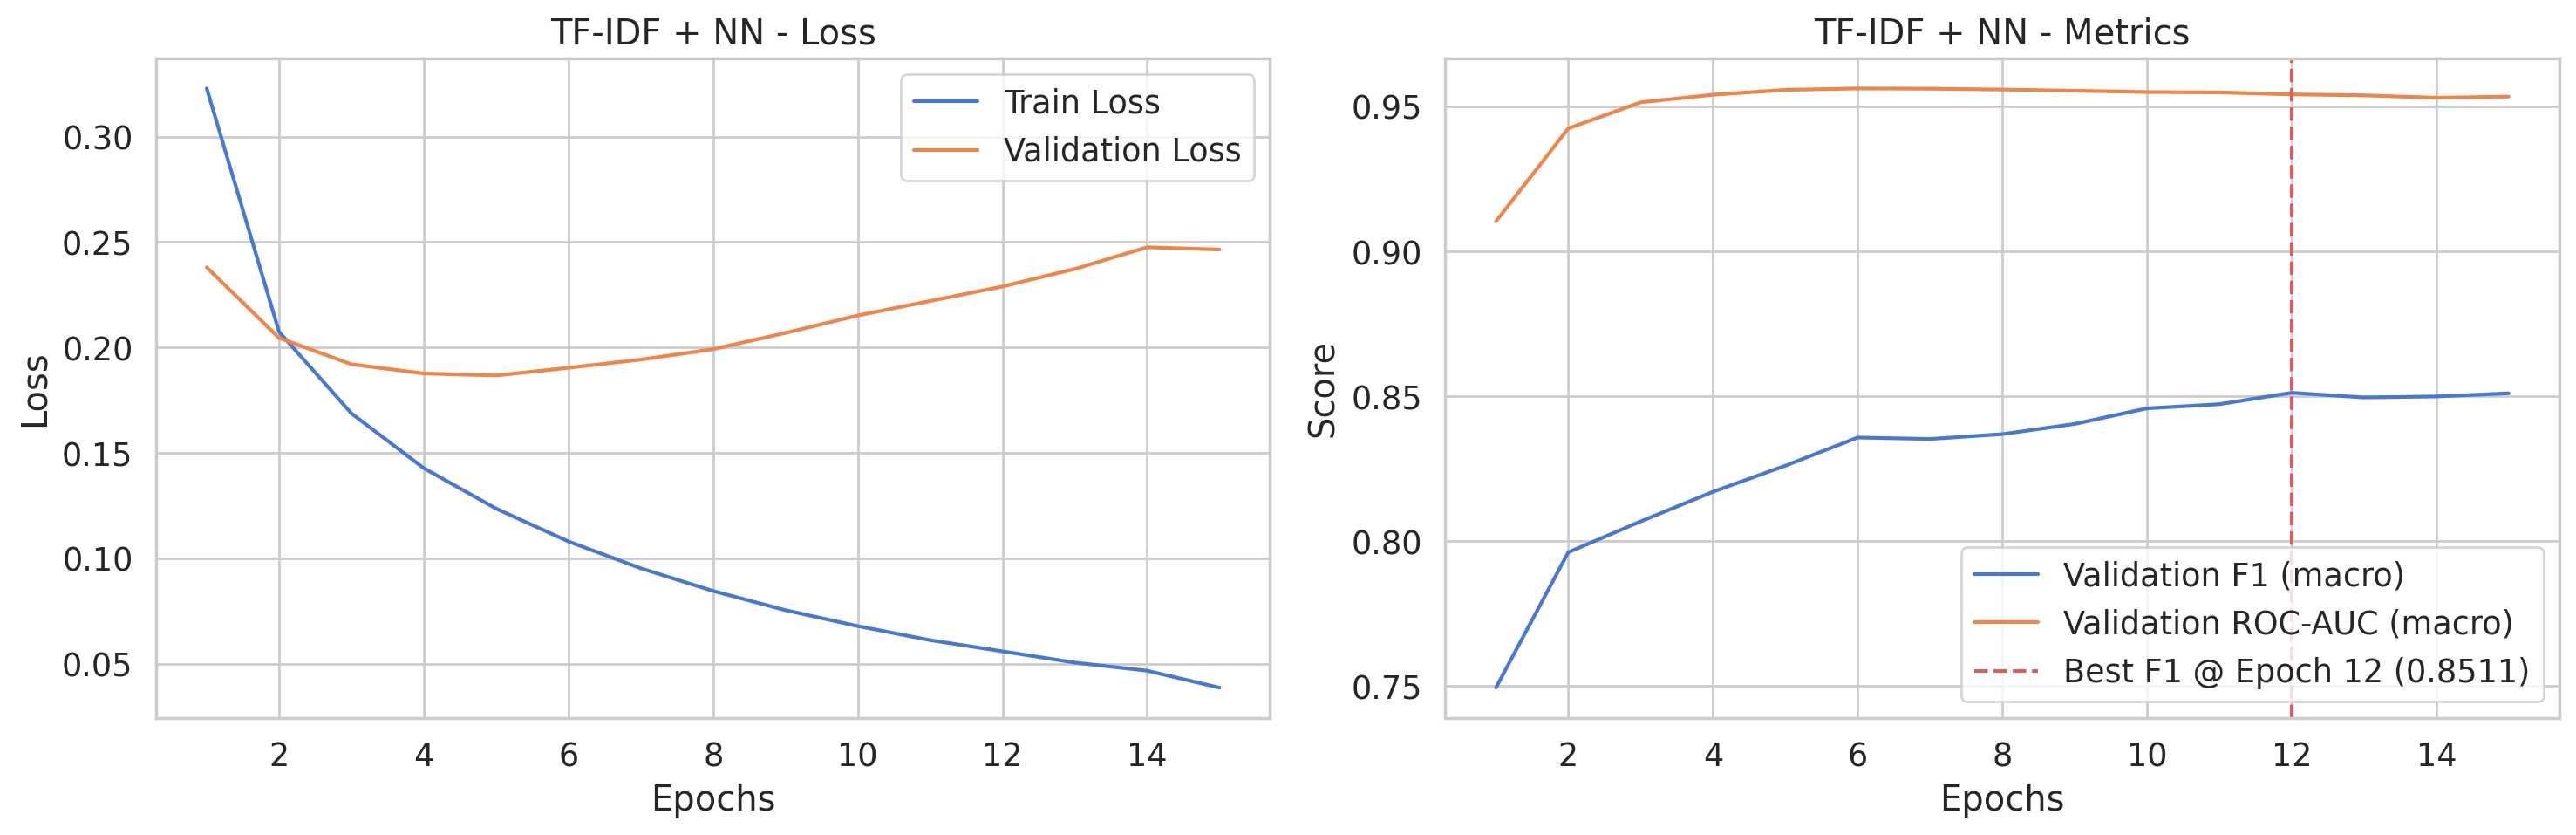

Лучший F1-macro для TF-IDF+NN на валидации: 0.8511


In [ ]:
print("\n--- Модель 1: TF-IDF + NN ---")


X_train['text_tfidf'] = X_train['text_tfidf'].fillna('')
X_val['text_tfidf'] = X_val['text_tfidf'].fillna('')

print("Обучение TF-IDF векторайзера...")
tfidf_vectorizer = TfidfVectorizer(max_features=15000,
                                   ngram_range=(1, 2))

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['text_tfidf'])
X_val_tfidf = tfidf_vectorizer.transform(X_val['text_tfidf'])

print(f"Размерность TF-IDF матрицы (Train): {X_train_tfidf.shape}")
print(f"Размерность TF-IDF матрицы (Val): {X_val_tfidf.shape}")

X_train_tfidf_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_val_tfidf_tensor = torch.tensor(X_val_tfidf.toarray(), dtype=torch.float32)


class SimpleDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset_tfidf = SimpleDataset(X_train_tfidf_tensor, y_train_tensor)
val_dataset_tfidf = SimpleDataset(X_val_tfidf_tensor, y_val_tensor)

train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=BATCH_SIZE, shuffle=True)
val_loader_tfidf = DataLoader(val_dataset_tfidf, batch_size=BATCH_SIZE, shuffle=False)


class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

input_dim_tfidf = X_train_tfidf.shape[1]
model_tfidf = SimpleMLP(input_dim=input_dim_tfidf, hidden_dim=256, output_dim=NUM_CLASSES).to(device)
print("\nАрхитектура модели TF-IDF+NN:")
print(model_tfidf)

criterion = nn.BCEWithLogitsLoss()
optimizer_tfidf = optim.Adam(model_tfidf.parameters(), lr=LEARNING_RATE_NN)
scheduler_tfidf = optim.lr_scheduler.ReduceLROnPlateau(optimizer_tfidf, mode='max', factor=0.1, patience=PATIENCE // 2, verbose=True)

print("\nЗапуск обучения TF-IDF+NN...")
model_tfidf, history_tfidf, best_f1_tfidf = train_model(
    model=model_tfidf,
    model_name='tfidf_nn',
    train_loader=train_loader_tfidf,
    val_loader=val_loader_tfidf,
    optimizer=optimizer_tfidf,
    criterion=criterion,
    scheduler=scheduler_tfidf,
    num_epochs=EPOCHS,
    patience=PATIENCE,
    device=device
)

plot_history(history_tfidf, 'TF-IDF + NN')
print(f"Лучший F1-macro для TF-IDF+NN на валидации: {best_f1_tfidf:.4f}")


--- Модель 2: Word2Vec + NN ---
Подготовка данных для Word2Vec (список списков токенов)...
Колонка text_w2v содержит строки, пытаемся преобразовать в списки...


  0%|          | 0/23654 [00:00<?, ?it/s]

  0%|          | 0/5914 [00:00<?, ?it/s]

Обучение модели Word2Vec...
Модель Word2Vec обучена. Размер словаря: 24674
Создание эмбеддингов документов...


Train W2V Emb:   0%|          | 0/23654 [00:00<?, ?it/s]

Val W2V Emb:   0%|          | 0/5914 [00:00<?, ?it/s]

Размерность эмбеддингов Word2Vec (Train): torch.Size([23654, 300])
Размерность эмбеддингов Word2Vec (Val): torch.Size([5914, 300])

Архитектура модели W2V+NN:
SimpleMLP(
  (fc1): Linear(in_features=300, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=20, bias=True)
)

Запуск обучения W2V+NN...


Epoch 1/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 1/15 | Time: 2.68s | Train Loss: 0.3726 | Val Loss: 0.3211 | Val F1: 0.7114 | Val ROC-AUC: 0.8568
Validation F1 improved (-1.0000 --> 0.7114). Saving model...


Epoch 2/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 2/15 | Time: 2.57s | Train Loss: 0.3131 | Val Loss: 0.2963 | Val F1: 0.7247 | Val ROC-AUC: 0.8820
Validation F1 improved (0.7114 --> 0.7247). Saving model...


Epoch 3/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 3/15 | Time: 2.45s | Train Loss: 0.2943 | Val Loss: 0.2832 | Val F1: 0.7395 | Val ROC-AUC: 0.8917
Validation F1 improved (0.7247 --> 0.7395). Saving model...


Epoch 4/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 4/15 | Time: 2.52s | Train Loss: 0.2846 | Val Loss: 0.2738 | Val F1: 0.7477 | Val ROC-AUC: 0.8988
Validation F1 improved (0.7395 --> 0.7477). Saving model...


Epoch 5/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 5/15 | Time: 2.54s | Train Loss: 0.2765 | Val Loss: 0.2677 | Val F1: 0.7491 | Val ROC-AUC: 0.9051
Validation F1 improved (0.7477 --> 0.7491). Saving model...


Epoch 6/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 6/15 | Time: 2.66s | Train Loss: 0.2704 | Val Loss: 0.2682 | Val F1: 0.7462 | Val ROC-AUC: 0.9088
Validation F1 did not improve from 0.7491. (1/3)


Epoch 7/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 7/15 | Time: 2.72s | Train Loss: 0.2656 | Val Loss: 0.2579 | Val F1: 0.7531 | Val ROC-AUC: 0.9120
Validation F1 improved (0.7491 --> 0.7531). Saving model...


Epoch 8/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 8/15 | Time: 2.49s | Train Loss: 0.2615 | Val Loss: 0.2540 | Val F1: 0.7578 | Val ROC-AUC: 0.9157
Validation F1 improved (0.7531 --> 0.7578). Saving model...


Epoch 9/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 9/15 | Time: 2.56s | Train Loss: 0.2575 | Val Loss: 0.2589 | Val F1: 0.7573 | Val ROC-AUC: 0.9171
Validation F1 did not improve from 0.7578. (1/3)


Epoch 10/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 10/15 | Time: 2.47s | Train Loss: 0.2548 | Val Loss: 0.2494 | Val F1: 0.7739 | Val ROC-AUC: 0.9205
Validation F1 improved (0.7578 --> 0.7739). Saving model...


Epoch 11/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 11/15 | Time: 2.60s | Train Loss: 0.2520 | Val Loss: 0.2498 | Val F1: 0.7740 | Val ROC-AUC: 0.9210
Validation F1 improved (0.7739 --> 0.7740). Saving model...


Epoch 12/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 12/15 | Time: 2.62s | Train Loss: 0.2492 | Val Loss: 0.2449 | Val F1: 0.7815 | Val ROC-AUC: 0.9231
Validation F1 improved (0.7740 --> 0.7815). Saving model...


Epoch 13/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 13/15 | Time: 2.64s | Train Loss: 0.2471 | Val Loss: 0.2443 | Val F1: 0.7783 | Val ROC-AUC: 0.9248
Validation F1 did not improve from 0.7815. (1/3)


Epoch 14/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 14/15 | Time: 2.47s | Train Loss: 0.2451 | Val Loss: 0.2429 | Val F1: 0.7794 | Val ROC-AUC: 0.9252
Validation F1 did not improve from 0.7815. (2/3)


Epoch 15/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 15/15 | Time: 2.53s | Train Loss: 0.2389 | Val Loss: 0.2394 | Val F1: 0.7830 | Val ROC-AUC: 0.9267
Validation F1 improved (0.7815 --> 0.7830). Saving model...
Loading best model weights from w2v_nn_best.pth (Val F1: 0.7830)


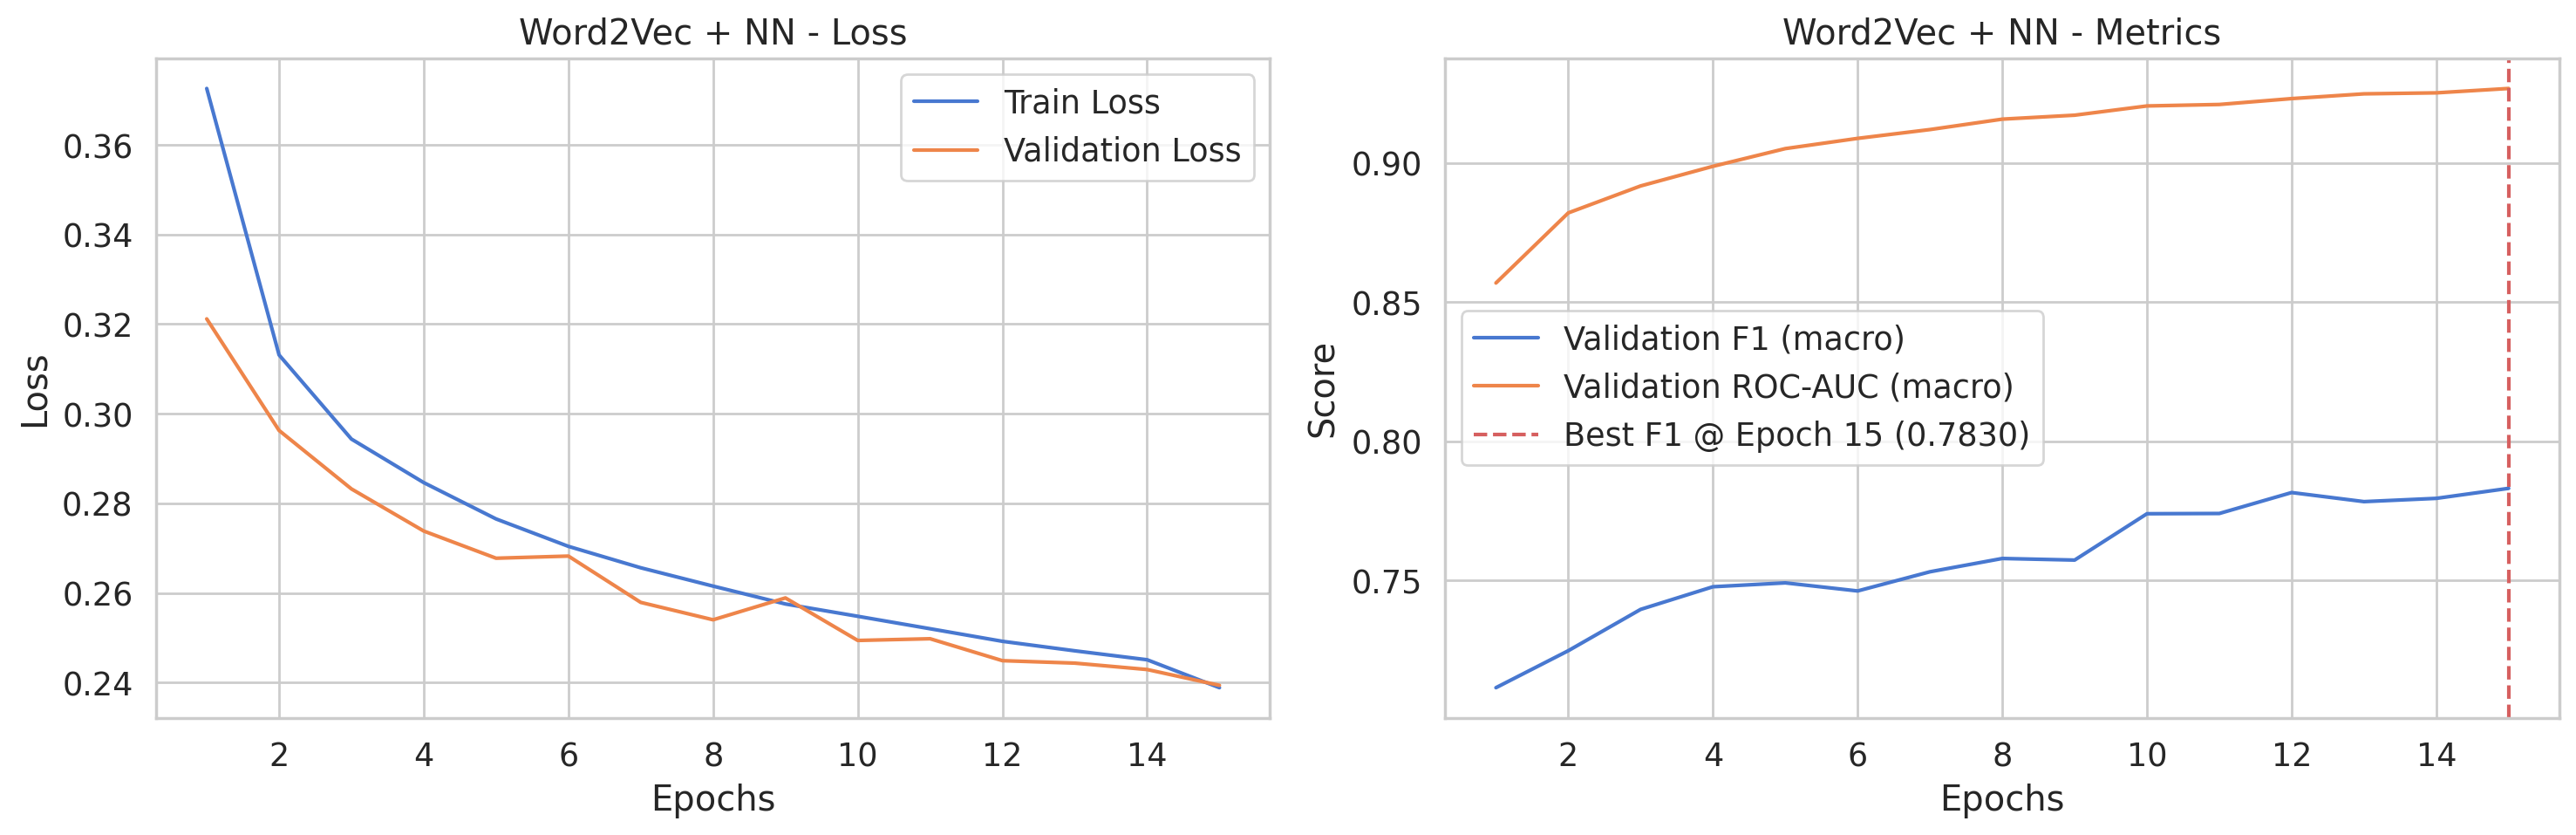

Лучший F1-macro для Word2Vec+NN на валидации: 0.7830


In [ ]:
from gensim.models import Word2Vec
import numpy as np

print("\n--- Модель 2: Word2Vec + NN ---")


X_train['text_w2v'] = X_train['text_w2v'].fillna('')
X_val['text_w2v'] = X_val['text_w2v'].fillna('')

print("Подготовка данных для Word2Vec (список списков токенов)...")

def safe_eval(x):
    if isinstance(x, str) and x.startswith('[') and x.endswith(']'):
        res = eval(x)
        return res if isinstance(res, list) else []
    elif isinstance(x, list):
        return x
    return []


from tqdm.auto import tqdm
tqdm.pandas()

first_valid_item_train = X_train['text_w2v'][X_train['text_w2v'] != ''].iloc[0] if not X_train['text_w2v'][X_train['text_w2v'] != ''].empty else []

if isinstance(first_valid_item_train, str):
     print("Колонка text_w2v содержит строки, пытаемся преобразовать в списки...")
     X_train['text_w2v_list'] = X_train['text_w2v'].progress_apply(safe_eval)
     X_val['text_w2v_list'] = X_val['text_w2v'].progress_apply(safe_eval)
     w2v_train_sentences = X_train['text_w2v_list'].tolist()
elif isinstance(first_valid_item_train, list):
     print("Колонка text_w2v уже содержит списки.")
     X_train['text_w2v_list'] = X_train['text_w2v'].copy()
     X_val['text_w2v_list'] = X_val['text_w2v'].copy()
     w2v_train_sentences = X_train['text_w2v_list'].tolist()
else:
     print("Колонка 'text_w2v' пуста или содержит неожиданный тип данных. Создаем пустые списки.")
     X_train['text_w2v_list'] = [[] for _ in range(len(X_train))]
     X_val['text_w2v_list'] = [[] for _ in range(len(X_val))]
     w2v_train_sentences = X_train['text_w2v_list'].tolist()


print("Обучение модели Word2Vec...")
valid_w2v_sentences = [s for s in w2v_train_sentences if s]
if not valid_w2v_sentences:
    print("Предупреждение: Нет валидных предложений для обучения Word2Vec. Модель не будет обучена.")
    w2v_model = None
else:
    w2v_model = Word2Vec(sentences=valid_w2v_sentences,
                         vector_size=W2V_VECTOR_SIZE,
                         window=W2V_WINDOW,
                         min_count=W2V_MIN_COUNT,
                         workers=os.cpu_count(),
                         sg=1,
                         seed=RANDOM_STATE)
    print(f"Модель Word2Vec обучена. Размер словаря: {len(w2v_model.wv.key_to_index)}")

def get_doc_embedding(tokens, model):
    if model is None:
        return np.zeros(W2V_VECTOR_SIZE)

    valid_tokens = [word for word in tokens if word in model.wv.key_to_index]
    if not valid_tokens:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[valid_tokens], axis=0)

print("Создание эмбеддингов документов...")
source_col_w2v = 'text_w2v_list'

X_train_w2v_emb = np.array([get_doc_embedding(tokens, w2v_model) for tokens in tqdm(X_train[source_col_w2v], desc="Train W2V Emb")])
X_val_w2v_emb = np.array([get_doc_embedding(tokens, w2v_model) for tokens in tqdm(X_val[source_col_w2v], desc="Val W2V Emb")])

X_train_w2v_tensor = torch.tensor(X_train_w2v_emb, dtype=torch.float32)
X_val_w2v_tensor = torch.tensor(X_val_w2v_emb, dtype=torch.float32)

print(f"Размерность эмбеддингов Word2Vec (Train): {X_train_w2v_tensor.shape}")
print(f"Размерность эмбеддингов Word2Vec (Val): {X_val_w2v_tensor.shape}")

train_dataset_w2v = SimpleDataset(X_train_w2v_tensor, y_train_tensor)
val_dataset_w2v = SimpleDataset(X_val_w2v_tensor, y_val_tensor)

train_loader_w2v = DataLoader(train_dataset_w2v, batch_size=BATCH_SIZE, shuffle=True)
val_loader_w2v = DataLoader(val_dataset_w2v, batch_size=BATCH_SIZE, shuffle=False)

model_w2v = SimpleMLP(input_dim=W2V_VECTOR_SIZE, hidden_dim=256, output_dim=NUM_CLASSES).to(device)
print("\nАрхитектура модели W2V+NN:")
print(model_w2v)

optimizer_w2v = optim.Adam(model_w2v.parameters(), lr=LEARNING_RATE_NN)
scheduler_w2v = optim.lr_scheduler.ReduceLROnPlateau(optimizer_w2v, mode='max', factor=0.1, patience=PATIENCE // 2, verbose=True)

print("\nЗапуск обучения W2V+NN...")
model_w2v, history_w2v, best_f1_w2v = train_model(
    model=model_w2v,
    model_name='w2v_nn',
    train_loader=train_loader_w2v,
    val_loader=val_loader_w2v,
    optimizer=optimizer_w2v,
    criterion=criterion,
    scheduler=scheduler_w2v,
    num_epochs=EPOCHS,
    patience=PATIENCE,
    device=device
)

plot_history(history_w2v, 'Word2Vec + NN')
print(f"Лучший F1-macro для Word2Vec+NN на валидации: {best_f1_w2v:.4f}")

del X_train_w2v_emb, X_val_w2v_emb, X_train_w2v_tensor, X_val_w2v_tensor
del train_dataset_w2v, val_dataset_w2v, train_loader_w2v, val_loader_w2v
import gc
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

In [ ]:
import nltk
from collections import Counter, defaultdict
from tqdm.auto import tqdm
tqdm.pandas()

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

X_train['text_seq'] = X_train['text_seq'].fillna('')
X_val['text_seq'] = X_val['text_seq'].fillna('')


tokenizer_seq = lambda text: nltk.word_tokenize(text, language='russian')

train_texts_seq = X_train['text_seq'].tolist()
train_tokens_seq = [tokenizer_seq(text) for text in tqdm(train_texts_seq, desc="Tokenizing Train")]

val_texts_seq = X_val['text_seq'].tolist()
val_tokens_seq = [tokenizer_seq(text) for text in tqdm(val_texts_seq, desc="Tokenizing Val")]


PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

word_counts = Counter(token for tokens in train_tokens_seq for token in tokens)
min_freq = 2
vocab = [token for token, count in word_counts.items() if count >= min_freq]
vocab = [PAD_TOKEN, UNK_TOKEN] + sorted(vocab)
vocab_size = len(vocab)

token_to_id = {token: i for i, token in enumerate(vocab)}
id_to_token = {i: token for token, i in token_to_id.items()}

PAD_ID = token_to_id[PAD_TOKEN]
UNK_ID = token_to_id[UNK_TOKEN]


def tokens_to_indices(tokens, token_to_id_map, unk_token_id):
    return [token_to_id_map.get(token, unk_token_id) for token in tokens]

train_indices_seq = [tokens_to_indices(tokens, token_to_id, UNK_ID) for tokens in tqdm(train_tokens_seq, desc="Indexing Train")]
val_indices_seq = [tokens_to_indices(tokens, token_to_id, UNK_ID) for tokens in tqdm(val_tokens_seq, desc="Indexing Val")]


def pad_sequence(indices, max_len, pad_id):
    if len(indices) < max_len:
        return indices + [pad_id] * (max_len - len(indices))
    else:
        return indices[:max_len]

X_train_seq_padded = [pad_sequence(inds, MAX_LENGTH_SEQ, PAD_ID) for inds in tqdm(train_indices_seq, desc="Padding Train")]
X_val_seq_padded = [pad_sequence(inds, MAX_LENGTH_SEQ, PAD_ID) for inds in tqdm(val_indices_seq, desc="Padding Val")]

X_train_seq_tensor = torch.tensor(X_train_seq_padded, dtype=torch.long)
X_val_seq_tensor = torch.tensor(X_val_seq_padded, dtype=torch.long)

print(f"Размер тензора последовательностей (Train): {X_train_seq_tensor.shape}")
print(f"Размер тензора последовательностей (Val): {X_val_seq_tensor.shape}")

class SimpleDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset_seq = SimpleDataset(X_train_seq_tensor, y_train_tensor)
val_dataset_seq = SimpleDataset(X_val_seq_tensor, y_val_tensor)

train_loader_seq = DataLoader(train_dataset_seq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_seq = DataLoader(val_dataset_seq, batch_size=BATCH_SIZE, shuffle=False)


--- Модели 3/4: CNN/RNN - Подготовка данных ---
Токенизация текстов для CNN/RNN...


Tokenizing Train:   0%|          | 0/23654 [00:00<?, ?it/s]

Tokenizing Val:   0%|          | 0/5914 [00:00<?, ?it/s]

Построение словаря...
Размер словаря: 61141 (включая <PAD> и <UNK>)
Преобразование токенов в индексы...


Indexing Train:   0%|          | 0/23654 [00:00<?, ?it/s]

Indexing Val:   0%|          | 0/5914 [00:00<?, ?it/s]

Паддинг/транкация последовательностей до длины 128...


Padding Train:   0%|          | 0/23654 [00:00<?, ?it/s]

Padding Val:   0%|          | 0/5914 [00:00<?, ?it/s]

Размер тензора последовательностей (Train): torch.Size([23654, 128])
Размер тензора последовательностей (Val): torch.Size([5914, 128])
Данные для CNN/RNN готовы.



--- Модель 3: CNN + Embedding ---

Архитектура модели CNN:
TextCNN(
  (embedding): Embedding(61141, 100, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=20, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

Запуск обучения CNN...


Epoch 1/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 1/15 | Time: 69.98s | Train Loss: 0.3821 | Val Loss: 0.2853 | Val F1: 0.7130 | Val ROC-AUC: 0.8698
Validation F1 improved (-1.0000 --> 0.7130). Saving model...


Epoch 2/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 2/15 | Time: 66.28s | Train Loss: 0.2733 | Val Loss: 0.2467 | Val F1: 0.7497 | Val ROC-AUC: 0.9098
Validation F1 improved (0.7130 --> 0.7497). Saving model...


Epoch 3/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 3/15 | Time: 65.89s | Train Loss: 0.2309 | Val Loss: 0.2308 | Val F1: 0.7608 | Val ROC-AUC: 0.9228
Validation F1 improved (0.7497 --> 0.7608). Saving model...


Epoch 4/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 4/15 | Time: 66.16s | Train Loss: 0.2031 | Val Loss: 0.2121 | Val F1: 0.7781 | Val ROC-AUC: 0.9287
Validation F1 improved (0.7608 --> 0.7781). Saving model...


Epoch 5/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 5/15 | Time: 66.14s | Train Loss: 0.1814 | Val Loss: 0.2143 | Val F1: 0.7787 | Val ROC-AUC: 0.9320
Validation F1 improved (0.7781 --> 0.7787). Saving model...


Epoch 6/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 6/15 | Time: 65.85s | Train Loss: 0.1641 | Val Loss: 0.2094 | Val F1: 0.7971 | Val ROC-AUC: 0.9351
Validation F1 improved (0.7787 --> 0.7971). Saving model...


Epoch 7/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 7/15 | Time: 66.42s | Train Loss: 0.1486 | Val Loss: 0.2124 | Val F1: 0.7976 | Val ROC-AUC: 0.9363
Validation F1 improved (0.7971 --> 0.7976). Saving model...


Epoch 8/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 8/15 | Time: 66.29s | Train Loss: 0.1360 | Val Loss: 0.2122 | Val F1: 0.8014 | Val ROC-AUC: 0.9370
Validation F1 improved (0.7976 --> 0.8014). Saving model...


Epoch 9/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 9/15 | Time: 66.15s | Train Loss: 0.1244 | Val Loss: 0.2125 | Val F1: 0.8032 | Val ROC-AUC: 0.9369
Validation F1 improved (0.8014 --> 0.8032). Saving model...


Epoch 10/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 10/15 | Time: 66.27s | Train Loss: 0.1151 | Val Loss: 0.2158 | Val F1: 0.8071 | Val ROC-AUC: 0.9377
Validation F1 improved (0.8032 --> 0.8071). Saving model...


Epoch 11/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 11/15 | Time: 66.06s | Train Loss: 0.1067 | Val Loss: 0.2274 | Val F1: 0.8067 | Val ROC-AUC: 0.9363
Validation F1 did not improve from 0.8071. (1/3)


Epoch 12/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 12/15 | Time: 65.87s | Train Loss: 0.0991 | Val Loss: 0.2277 | Val F1: 0.8128 | Val ROC-AUC: 0.9374
Validation F1 improved (0.8071 --> 0.8128). Saving model...


Epoch 13/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 13/15 | Time: 66.03s | Train Loss: 0.0936 | Val Loss: 0.2418 | Val F1: 0.8065 | Val ROC-AUC: 0.9366
Validation F1 did not improve from 0.8128. (1/3)


Epoch 14/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 14/15 | Time: 66.15s | Train Loss: 0.0868 | Val Loss: 0.2355 | Val F1: 0.8153 | Val ROC-AUC: 0.9368
Validation F1 improved (0.8128 --> 0.8153). Saving model...


Epoch 15/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 15/15 | Time: 66.42s | Train Loss: 0.0835 | Val Loss: 0.2485 | Val F1: 0.8138 | Val ROC-AUC: 0.9358
Validation F1 did not improve from 0.8153. (1/3)
Loading best model weights from cnn_emb_best.pth (Val F1: 0.8153)


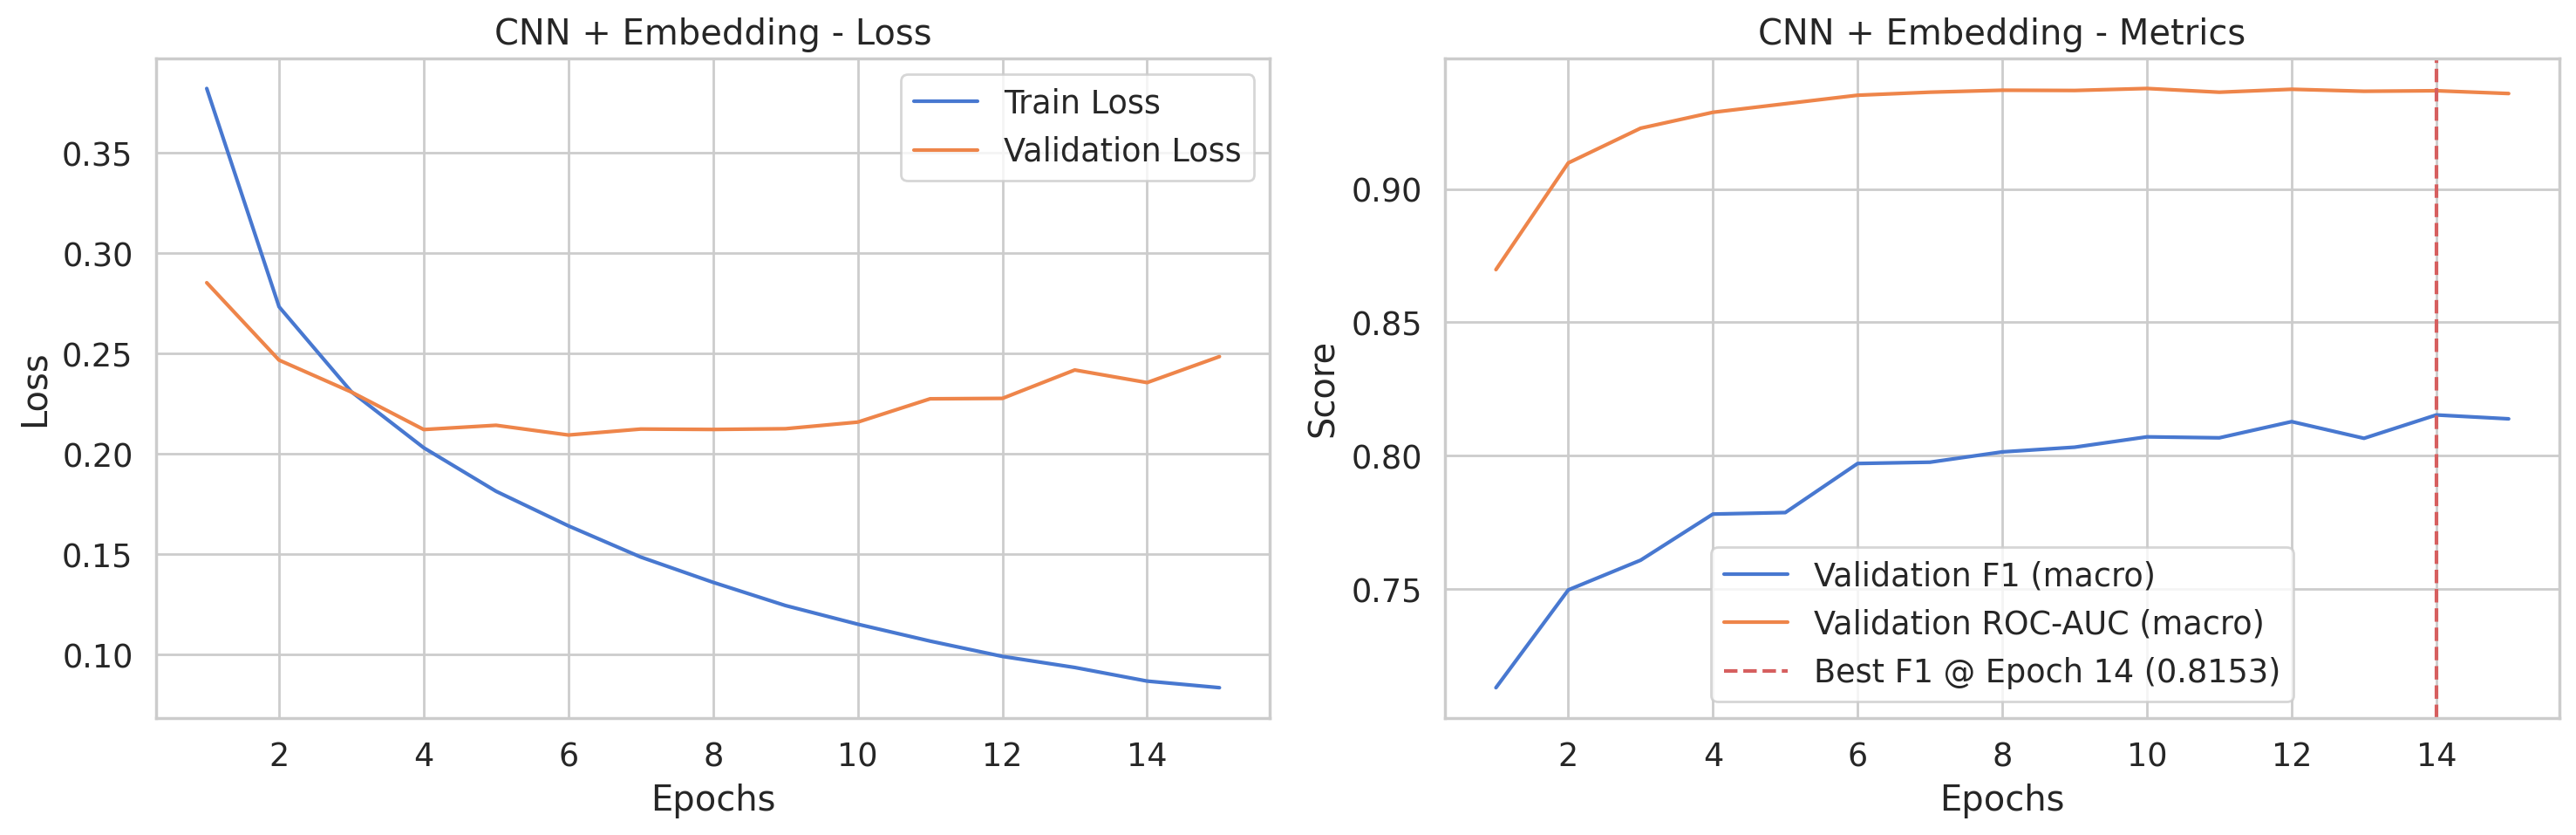

Лучший F1-macro для CNN+Embedding на валидации: 0.8153


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm

print("\n--- Модель 3: CNN + Embedding ---")

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, filter_sizes, output_dim, dropout_rate=0.4, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim,
                      out_channels=num_filters,
                      kernel_size=fs)
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))

        embedded = embedded.permute(0, 2, 1)

        conved = [torch.relu(conv(embedded)) for conv in self.convs]

        pooled = [torch.max_pool1d(conv, conv.shape[-1]).squeeze(-1) for conv in conved]

        cat = self.dropout(torch.cat(pooled, dim=-1))

        return self.fc(cat)

EMBEDDING_DIM_CNN = 100
NUM_FILTERS_CNN = 100
FILTER_SIZES_CNN = [3, 4, 5]

model_cnn = TextCNN(
    vocab_size=vocab_size,
    embed_dim=EMBEDDING_DIM_CNN,
    num_filters=NUM_FILTERS_CNN,
    filter_sizes=FILTER_SIZES_CNN,
    output_dim=NUM_CLASSES,
    pad_idx=PAD_ID
).to(device)

print("\nАрхитектура модели CNN:")
print(model_cnn)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
           nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
         nn.init.normal_(m.weight, mean=0, std=0.1)
         if m.padding_idx is not None:
             with torch.no_grad():
                 m.weight[m.padding_idx].fill_(0)


model_cnn.apply(init_weights)

criterion = nn.BCEWithLogitsLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=LEARNING_RATE_SEQ)
scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode='max', factor=0.1, patience=PATIENCE // 2, verbose=True)

print("\nЗапуск обучения CNN...")
model_cnn, history_cnn, best_f1_cnn = train_model(
    model=model_cnn,
    model_name='cnn_emb',
    train_loader=train_loader_seq,
    val_loader=val_loader_seq,
    optimizer=optimizer_cnn,
    criterion=criterion,
    scheduler=scheduler_cnn,
    num_epochs=EPOCHS,
    patience=PATIENCE,
    device=device
)

plot_history(history_cnn, 'CNN + Embedding')
print(f"Лучший F1-macro для CNN+Embedding на валидации: {best_f1_cnn:.4f}")


--- Модель 4: RNN (LSTM) + Embedding ---

Архитектура модели RNN (LSTM):
TextRNN(
  (embedding): Embedding(61141, 100, padding_idx=0)
  (rnn): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=256, out_features=20, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

Запуск обучения RNN...


Epoch 1/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 1/15 | Time: 10.12s | Train Loss: 0.3474 | Val Loss: 0.2768 | Val F1: 0.7272 | Val ROC-AUC: 0.8798
Validation F1 improved (-1.0000 --> 0.7272). Saving model...


Epoch 2/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 2/15 | Time: 10.00s | Train Loss: 0.2649 | Val Loss: 0.2497 | Val F1: 0.7392 | Val ROC-AUC: 0.8985
Validation F1 improved (0.7272 --> 0.7392). Saving model...


Epoch 3/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 3/15 | Time: 10.09s | Train Loss: 0.2361 | Val Loss: 0.2351 | Val F1: 0.7508 | Val ROC-AUC: 0.9108
Validation F1 improved (0.7392 --> 0.7508). Saving model...


Epoch 4/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 4/15 | Time: 9.95s | Train Loss: 0.2142 | Val Loss: 0.2227 | Val F1: 0.7586 | Val ROC-AUC: 0.9194
Validation F1 improved (0.7508 --> 0.7586). Saving model...


Epoch 5/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 5/15 | Time: 9.95s | Train Loss: 0.1939 | Val Loss: 0.2199 | Val F1: 0.7662 | Val ROC-AUC: 0.9242
Validation F1 improved (0.7586 --> 0.7662). Saving model...


Epoch 6/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 6/15 | Time: 9.85s | Train Loss: 0.1762 | Val Loss: 0.2085 | Val F1: 0.7776 | Val ROC-AUC: 0.9275
Validation F1 improved (0.7662 --> 0.7776). Saving model...


Epoch 7/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 7/15 | Time: 9.77s | Train Loss: 0.1587 | Val Loss: 0.2045 | Val F1: 0.7818 | Val ROC-AUC: 0.9317
Validation F1 improved (0.7776 --> 0.7818). Saving model...


Epoch 8/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 8/15 | Time: 9.81s | Train Loss: 0.1436 | Val Loss: 0.2053 | Val F1: 0.7957 | Val ROC-AUC: 0.9324
Validation F1 improved (0.7818 --> 0.7957). Saving model...


Epoch 9/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 9/15 | Time: 9.88s | Train Loss: 0.1315 | Val Loss: 0.2065 | Val F1: 0.7883 | Val ROC-AUC: 0.9315
Validation F1 did not improve from 0.7957. (1/3)


Epoch 10/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 10/15 | Time: 9.83s | Train Loss: 0.1199 | Val Loss: 0.2081 | Val F1: 0.7987 | Val ROC-AUC: 0.9370
Validation F1 improved (0.7957 --> 0.7987). Saving model...


Epoch 11/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 11/15 | Time: 9.90s | Train Loss: 0.1101 | Val Loss: 0.2137 | Val F1: 0.8004 | Val ROC-AUC: 0.9352
Validation F1 improved (0.7987 --> 0.8004). Saving model...


Epoch 12/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 12/15 | Time: 9.89s | Train Loss: 0.1001 | Val Loss: 0.2191 | Val F1: 0.8093 | Val ROC-AUC: 0.9376
Validation F1 improved (0.8004 --> 0.8093). Saving model...


Epoch 13/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 13/15 | Time: 9.87s | Train Loss: 0.0913 | Val Loss: 0.2240 | Val F1: 0.8129 | Val ROC-AUC: 0.9373
Validation F1 improved (0.8093 --> 0.8129). Saving model...


Epoch 14/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 14/15 | Time: 9.87s | Train Loss: 0.0845 | Val Loss: 0.2310 | Val F1: 0.8125 | Val ROC-AUC: 0.9362
Validation F1 did not improve from 0.8129. (1/3)


Epoch 15/15 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 15/15 | Time: 9.85s | Train Loss: 0.0766 | Val Loss: 0.2372 | Val F1: 0.8147 | Val ROC-AUC: 0.9346
Validation F1 improved (0.8129 --> 0.8147). Saving model...
Loading best model weights from rnn_emb_best.pth (Val F1: 0.8147)


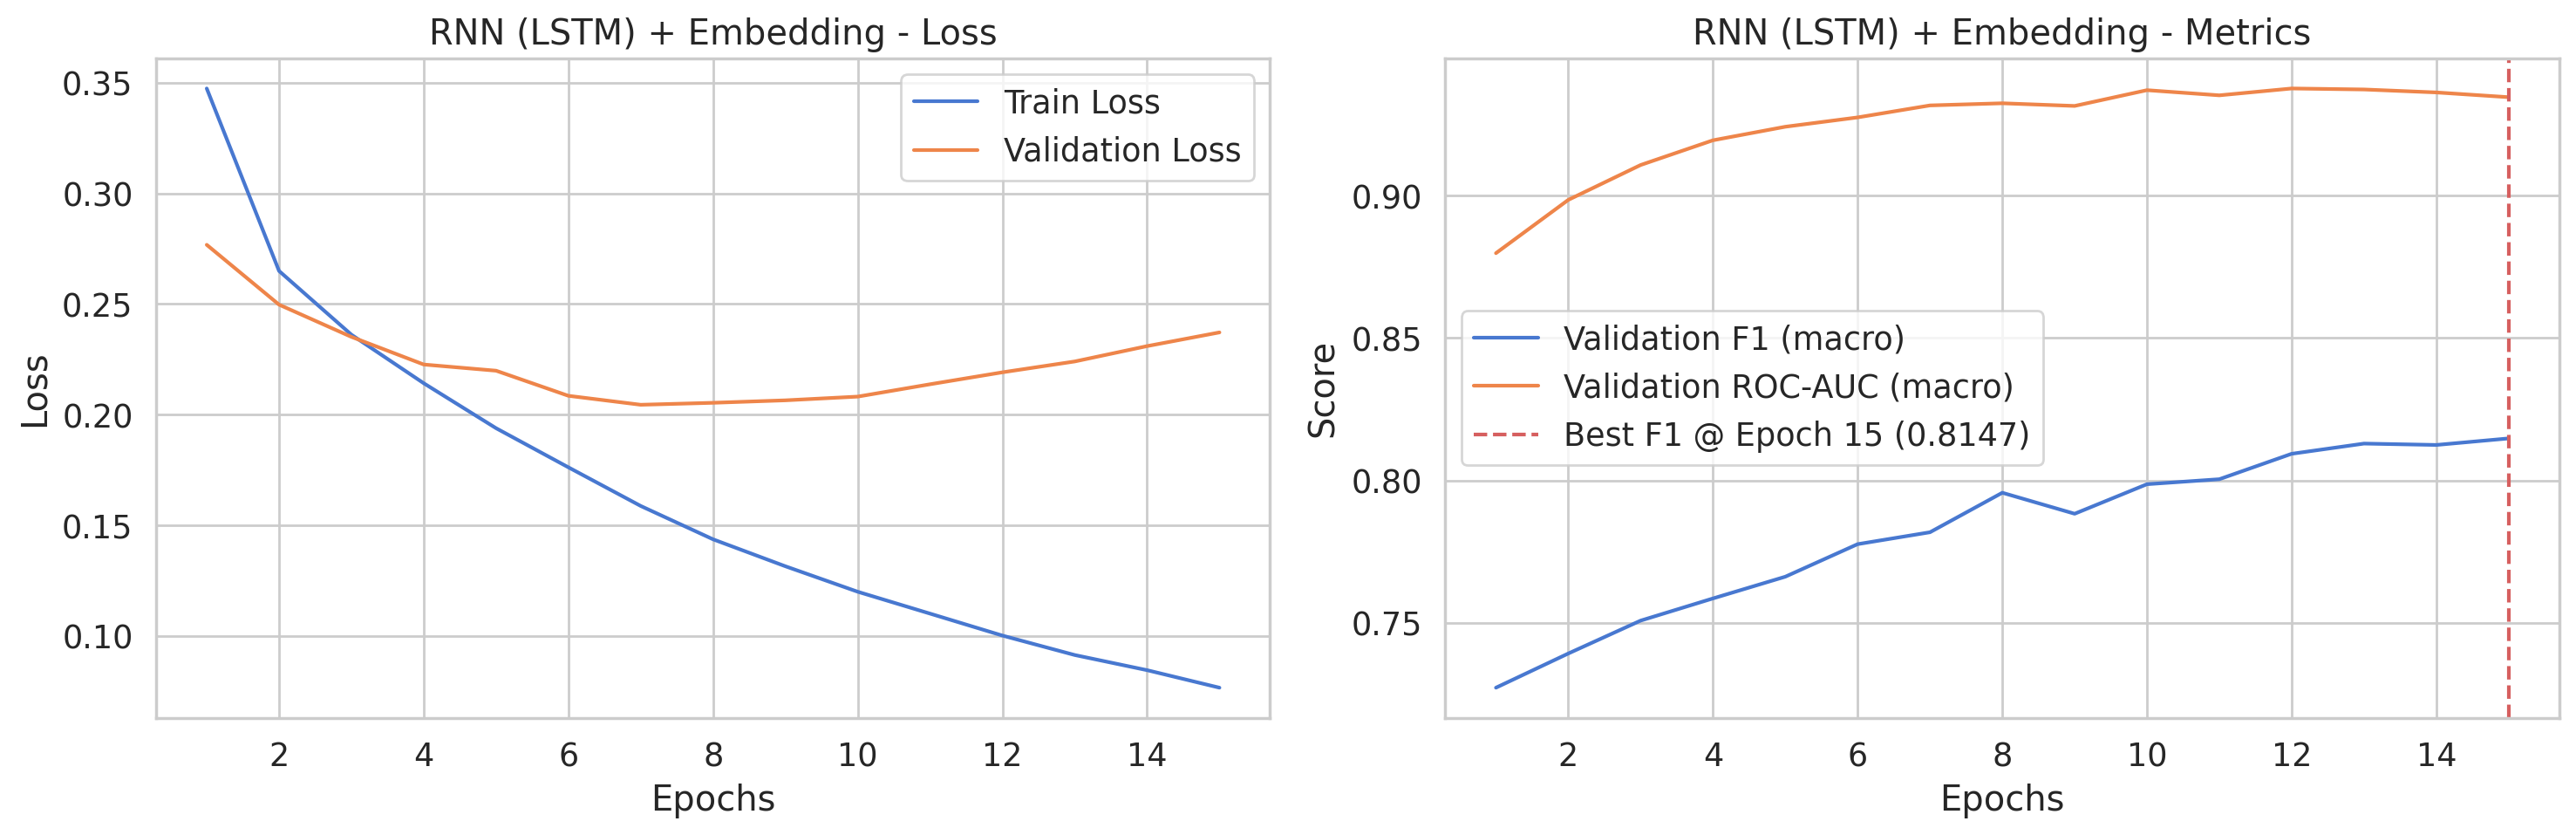

Лучший F1-macro для RNN+Embedding на валидации: 0.8147


In [ ]:
print("\n--- Модель 4: RNN (LSTM) + Embedding ---")

class TextRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate=0.4, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embed_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           batch_first=True,
                           dropout=dropout_rate if n_layers > 1 else 0)
        fc_in_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_in_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))

        outputs, (hidden, cell) = self.rnn(embedded)

        if self.rnn.bidirectional:
             hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
             hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

EMBEDDING_DIM_RNN = 100
HIDDEN_DIM_RNN = 128
N_LAYERS_RNN = 2
BIDIRECTIONAL_RNN = True

model_rnn = TextRNN(
    vocab_size=vocab_size,
    embed_dim=EMBEDDING_DIM_RNN,
    hidden_dim=HIDDEN_DIM_RNN,
    output_dim=NUM_CLASSES,
    n_layers=N_LAYERS_RNN,
    bidirectional=BIDIRECTIONAL_RNN,
    pad_idx=PAD_ID
).to(device)

print("\nАрхитектура модели RNN (LSTM):")
print(model_rnn)

model_rnn.apply(init_weights)

criterion = nn.BCEWithLogitsLoss()
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=LEARNING_RATE_SEQ)
scheduler_rnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_rnn, mode='max', factor=0.1, patience=PATIENCE // 2, verbose=True)

print("\nЗапуск обучения RNN...")
model_rnn, history_rnn, best_f1_rnn = train_model(
    model=model_rnn,
    model_name='rnn_emb',
    train_loader=train_loader_seq,
    val_loader=val_loader_seq,
    optimizer=optimizer_rnn,
    criterion=criterion,
    scheduler=scheduler_rnn,
    num_epochs=EPOCHS,
    patience=PATIENCE,
    device=device
)

plot_history(history_rnn, 'RNN (LSTM) + Embedding')
print(f"Лучший F1-macro для RNN+Embedding на валидации: {best_f1_rnn:.4f}")

del X_train_seq_tensor, X_val_seq_tensor, train_dataset_seq, val_dataset_seq, train_loader_seq, val_loader_seq
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

In [ ]:
print("\n--- Модель 5: BERT-like ---")


X_train['text_bert'] = X_train['text_bert'].fillna('')
X_val['text_bert'] = X_val['text_bert'].fillna('')


print(f"Загрузка токенизатора {BERT_MODEL_NAME}...")
tokenizer_bert = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)


print("Токенизация данных для BERT...")


train_texts_bert = [str(text) for text in X_train['text_bert'].tolist()]
val_texts_bert = [str(text) for text in X_val['text_bert'].tolist()]


train_encodings = tokenizer_bert(
    train_texts_bert,
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH_BERT,
    return_tensors='pt'
)
val_encodings = tokenizer_bert(
    val_texts_bert,
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH_BERT,
    return_tensors='pt'
)

class BertDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx].clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

train_dataset_bert = BertDataset(train_encodings, y_train_tensor)
val_dataset_bert = BertDataset(val_encodings, y_val_tensor)

BATCH_SIZE_BERT = 16 if torch.cuda.is_available() else BATCH_SIZE
print(f"Используем BATCH_SIZE={BATCH_SIZE_BERT} для BERT.")

train_loader_bert = DataLoader(train_dataset_bert, batch_size=BATCH_SIZE_BERT, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=BATCH_SIZE_BERT, shuffle=False)


print(f"Загрузка модели {BERT_MODEL_NAME} для Sequence Classification...")
model_bert = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL_NAME,
    num_labels=NUM_CLASSES,
    problem_type="multi_label_classification"
).to(device)


print("\nАрхитектура модели BERT загружена.")

criterion = nn.BCEWithLogitsLoss()

optimizer_bert = AdamW(model_bert.parameters(), lr=LEARNING_RATE_BERT, eps=1e-8)

EPOCHS_BERT = 5
PATIENCE_BERT = 2

total_steps = len(train_loader_bert) * EPOCHS_BERT
num_warmup_steps = int(total_steps * 0.1)

scheduler_bert = get_linear_schedule_with_warmup(
    optimizer_bert,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)

print("\nЗапуск обучения BERT...")
model_bert, history_bert, best_f1_bert = train_model(
    model=model_bert,
    model_name='bert',
    train_loader=train_loader_bert,
    val_loader=val_loader_bert,
    optimizer=optimizer_bert,
    criterion=criterion,
    scheduler=scheduler_bert,
    num_epochs=EPOCHS_BERT,
    patience=PATIENCE_BERT,
    device=device
)

plot_history(history_bert, 'BERT')
print(f"Лучший F1-macro для BERT на валидации: {best_f1_bert:.4f}")


--- Модель 5: BERT-like ---
Загрузка токенизатора bert-base-multilingual-cased...


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:898: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Токенизация данных для BERT...
Используем BATCH_SIZE=16 для BERT.
Загрузка модели bert-base-multilingual-cased для Sequence Classification...


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Архитектура модели BERT загружена.

Запуск обучения BERT...


Epoch 1/5 [Train]:   0%|          | 0/1479 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 1/5 | Time: 625.03s | Train Loss: 0.6851 | Val Loss: 0.6845 | Val F1: 0.3983 | Val ROC-AUC: 0.4872
Validation F1 improved (-1.0000 --> 0.3983). Saving model...


Epoch 2/5 [Train]:   0%|          | 0/1479 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/370 [00:00<?, ?it/s]

Epoch 2/5 | Time: 624.67s | Train Loss: 0.6775 | Val Loss: 0.6695 | Val F1: 0.4491 | Val ROC-AUC: 0.5146
Validation F1 improved (0.3983 --> 0.4491). Saving model...


Epoch 3/5 [Train]:   0%|          | 0/1479 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
best_f1_bert = 0.4491

In [ ]:
print("\n--- Сводка F1-macro на валидационной выборке ---")
print(f"1. TF-IDF + NN:        {best_f1_tfidf:.4f}")
print(f"2. Word2Vec + NN:      {best_f1_w2v:.4f}")
print(f"3. CNN + Embedding:    {best_f1_cnn:.4f}")
print(f"4. RNN (LSTM) + Emb:   {best_f1_rnn:.4f}")
print(f"5. BERT-like:          {best_f1_bert:.4f}")

best_model_idx = np.argmax([best_f1_tfidf, best_f1_w2v, best_f1_cnn, best_f1_rnn, best_f1_bert])
model_names = ['TF-IDF+NN', 'W2V+NN', 'CNN+Emb', 'RNN+Emb', 'BERT']
print(f"\nЛучшая модель по F1-macro на валидации: {model_names[best_model_idx]}")


--- Сводка F1-macro на валидационной выборке ---
1. TF-IDF + NN:        0.8533
2. Word2Vec + NN:      0.7830
3. CNN + Embedding:    0.8153
4. RNN (LSTM) + Emb:   0.8147
5. BERT-like:          0.4491

Лучшая модель по F1-macro на валидации: TF-IDF+NN


**Выводы по Этапу 3: Обучение Моделей**

На данном этапе были реализованы, обучены и оценены пять различных архитектур моделей для задачи мультилейбл классификации:

1.  **TF-IDF + Нейронная сеть (MLP):**
    *   Тексты были векторизованы с использованием TF-IDF (с ограничением на 15 000 признаков и использованием униграмм/биграмм).
    *   Простая нейронная сеть (многослойный перцептрон) была обучена на этих TF-IDF признаках.
    *   **Результат:** Эта модель показала **наилучший результат** на валидационной выборке с **F1-macro = 0.8533**. Это очень сильный результат для относительно простого подхода и служит отличным бейзлайном.

2.  **Word2Vec + Нейронная сеть (MLP):**
    *   Модель Word2Vec (Skip-gram) была обучена на токенизированных текстах из обучающей выборки для получения векторных представлений слов (эмбеддингов).
    *   Эмбеддинги документов были получены путем усреднения векторов слов.
    *   Нейронная сеть (аналогичная той, что использовалась с TF-IDF) была обучена на этих эмбеддингах документов.
    *   **Результат:** F1-macro = **0.7830**. Результат заметно ниже, чем у TF-IDF. Это может быть связано с тем, что простое усреднение векторов слов не всегда эффективно улавливает семантику всего текста для классификации, или что обученная с нуля модель Word2Vec на данном объеме данных не смогла создать достаточно качественные эмбеддинги по сравнению с информативностью частотных признаков TF-IDF.

3.  **Свёрточная нейронная сеть (CNN) + Встроенный Embedding:**
    *   Тексты были токенизированы, преобразованы в последовательности индексов и дополнены/обрезаны до фиксированной длины.
    *   Архитектура CNN включала слой эмбеддингов (обучаемый с нуля), несколько сверточных слоев с разными размерами ядер и слой Global Max Pooling.
    *   **Результат:** F1-macro = **0.8153**. CNN показала хороший результат, превзойдя Word2Vec+NN, но уступив TF-IDF+NN. Это демонстрирует способность CNN извлекать локальные признаки из последовательностей текста.

4.  **Рекуррентная нейронная сеть (RNN/LSTM) + Встроенный Embedding:**
    *   Использовалась та же подготовка данных (индексы, паддинг), что и для CNN.
    *   Была применена двунаправленная LSTM сеть со слоем эмбеддингов (обучаемым с нуля).
    *   **Результат:** F1-macro = **0.8147**. Результат RNN (LSTM) очень близок к результату CNN, что часто наблюдается на задачах классификации текста. Модель также не смогла превзойти TF-IDF+NN.

5.  **BERT-like модель (bert-base-multilingual-cased):**
    *   Использовался предобученный токенизатор и модель `bert-base-multilingual-cased` с добавлением классификационной головы для мультилейбл задачи.
    *   Обучение было остановлено после ~2-х полных эпох из-за медленной скорости сходимости и относительно низких промежуточных результатов по сравнению с другими моделями.
    *   **Результат (после 2 эпох):** F1-macro = **0.4491**. На момент остановки, BERT показывал значительно более низкое качество по сравнению с другими подходами. Для достижения своего потенциала BERT обычно требует более длительного и тщательного fine-tuning, подбора гиперпараметров (learning rate, batch size, количество эпох, warmup) и, возможно, более мощных вычислительных ресурсов.

**Общие итоги и выбор лучшего пайплайна на данный момент:**

*   **Лучший пайплайн:** На текущий момент, связка **TF-IDF + Нейронная сеть (MLP)** продемонстрировала наилучшую производительность на валидационной выборке.
*   **Сложность vs. Качество:** Более сложные модели (CNN, RNN и особенно BERT на ранних стадиях обучения) не смогли превзойти более простой, но хорошо настроенный TF-IDF подход. Это подчеркивает важность правильного выбора признаков и того, что "больше не всегда лучше", особенно при ограниченных данных или времени на тюнинг.
*   **Дальнейшие шаги для BERT:** Если бы ресурсы и время позволяли, дальнейший fine-tuning BERT (возможно, с другой архитектурой или предобученной моделью, более специфичной для русского языка, например, `DeepPavlov/rubert-base-cased`) мог бы потенциально улучшить его результат.

Для следующего этапа (аугментация данных) имеет смысл использовать **лучший текущий пайплайн (TF-IDF + NN)** для оценки влияния аугментации.

In [10]:
!pip install razdel

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import random
import re
import time
from razdel import tokenize as razdel_tokenize

torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Устройство для обучения генератора и переобучения основной модели: {device}")

PAD_TOKEN_GEN_STR = "<PAD_GEN>"
SOS_TOKEN_GEN_STR = "<SOS_GEN>"
EOS_TOKEN_GEN_STR = "<EOS_GEN>"
UNK_TOKEN_GEN_STR = "<UNK_GEN>"

MAX_LEN_GEN = 70
VOCAB_SIZE_GEN_MAX = 10000
MIN_FREQ_GEN = 3

EMBED_DIM_GEN = 256
HIDDEN_DIM_GEN = 512
NUM_LAYERS_GEN = 1
DROPOUT_GEN = 0.3
LEARNING_RATE_GEN = 0.001
EPOCHS_GEN = 15
BATCH_SIZE_GEN = 64
TEACHER_FORCING_RATIO_GEN = 0.7

set_seed(RANDOM_STATE)


from pymystem3 import Mystem
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
mystem = Mystem()
russian_stopwords = stopwords.words("russian")

Устройство для обучения генератора и переобучения основной модели: cuda


In [ ]:
print("Подготовка данных для генератора...")
source_texts_for_gen = X_train['text_seq'].fillna('').tolist()

print(f"Количество текстов для создания словаря генератора: {len(source_texts_for_gen)}")


tokenizer_seq = lambda text: [token.text for token in razdel_tokenize(str(text).lower())]

tokenized_texts_gen = [tokenizer_seq(text) for text in tqdm(source_texts_for_gen, desc="Токенизация текстов (ген.)")]


tokenized_texts_gen = [tokenizer_seq(text) for text in tqdm(source_texts_for_gen, desc="Токенизация текстов (ген.)")]

word_counts_gen = Counter(token for tokens_list in tokenized_texts_gen for token in tokens_list)
vocab_gen_list = [token for token, count in word_counts_gen.items() if count >= MIN_FREQ_GEN]
if len(vocab_gen_list) > VOCAB_SIZE_GEN_MAX - 4:
    vocab_gen_list = [pair[0] for pair in word_counts_gen.most_common(VOCAB_SIZE_GEN_MAX - 4)]

vocab_gen = [PAD_TOKEN_GEN_STR, SOS_TOKEN_GEN_STR, EOS_TOKEN_GEN_STR, UNK_TOKEN_GEN_STR] + sorted(list(set(vocab_gen_list)))

token_to_id_gen = {token: i for i, token in enumerate(vocab_gen)}
id_to_token_gen = {i: token for token, i in token_to_id_gen.items()}
vocab_size_gen = len(vocab_gen)

PAD_ID_GEN = token_to_id_gen[PAD_TOKEN_GEN_STR]
SOS_ID_GEN = token_to_id_gen[SOS_TOKEN_GEN_STR]
EOS_ID_GEN = token_to_id_gen[EOS_TOKEN_GEN_STR]
UNK_ID_GEN = token_to_id_gen[UNK_TOKEN_GEN_STR]

print(f"Размер словаря для генератора: {vocab_size_gen}")
print(f"PAD_ID_GEN: {PAD_ID_GEN}, SOS_ID_GEN: {SOS_ID_GEN}, EOS_ID_GEN: {EOS_ID_GEN}, UNK_ID_GEN: {UNK_ID_GEN}")

target_sequences_ids = []
for tokens in tqdm(tokenized_texts_gen, desc="Индексация и паддинг (ген.)"):
    ids = [SOS_ID_GEN] + [token_to_id_gen.get(token, UNK_ID_GEN) for token in tokens] + [EOS_ID_GEN]
    ids = ids[:MAX_LEN_GEN]
    ids += [PAD_ID_GEN] * (MAX_LEN_GEN - len(ids))
    target_sequences_ids.append(ids)

target_sequences_tensor = torch.tensor(target_sequences_ids, dtype=torch.long)

print(f"Размер тензора целевых последовательностей (ген.): {target_sequences_tensor.shape}")
print(f"Размер тензора меток (вход для энкодера ген.): {y_train_tensor.shape}")

class LabelTextDataset(Dataset):
    def __init__(self, label_vectors, text_sequences):
        self.label_vectors = label_vectors
        self.text_sequences = text_sequences

    def __len__(self):
        return len(self.label_vectors)

    def __getitem__(self, idx):
        return self.label_vectors[idx], self.text_sequences[idx]

gen_train_dataset = LabelTextDataset(y_train_tensor, target_sequences_tensor)
gen_train_loader = DataLoader(gen_train_dataset, batch_size=BATCH_SIZE_GEN, shuffle=True, drop_last=True)

print("Данные для генератора подготовлены.")

Подготовка данных для генератора...
Количество текстов для создания словаря генератора: 23654


Токенизация текстов (ген.):   0%|          | 0/23654 [00:00<?, ?it/s]

Токенизация текстов (ген.):   0%|          | 0/23654 [00:00<?, ?it/s]

Размер словаря для генератора: 10000
PAD_ID_GEN: 0, SOS_ID_GEN: 1, EOS_ID_GEN: 2, UNK_ID_GEN: 3


Индексация и паддинг (ген.):   0%|          | 0/23654 [00:00<?, ?it/s]

Размер тензора целевых последовательностей (ген.): torch.Size([23654, 70])
Размер тензора меток (вход для энкодера ген.): torch.Size([23654, 20])
Данные для генератора подготовлены.


In [ ]:
class LabelEncoder(nn.Module):
    def __init__(self, num_labels, hidden_dim, num_layers_lstm):
        super().__init__()
        self.num_labels = num_labels
        self.hidden_dim = hidden_dim
        self.num_layers_lstm = num_layers_lstm

        self.label_to_hidden = nn.Linear(num_labels, hidden_dim * num_layers_lstm)
        self.label_to_cell = nn.Linear(num_labels, hidden_dim * num_layers_lstm)
        self.relu = nn.ReLU()

    def forward(self, label_vector):

        hidden_flat = self.relu(self.label_to_hidden(label_vector))
        cell_flat = self.relu(self.label_to_cell(label_vector))

        hidden = hidden_flat.view(self.num_layers_lstm, -1, self.hidden_dim)
        cell = cell_flat.view(self.num_layers_lstm, -1, self.hidden_dim)

        return hidden, cell

class SimpleDecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout_p):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_ID_GEN)
        self.dropout = nn.Dropout(dropout_p)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_p if num_layers > 1 else 0)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_token_ids, hidden_state, cell_state):

        embedded = self.dropout(self.embedding(input_token_ids))

        output, (hidden_state, cell_state) = self.lstm(embedded, (hidden_state, cell_state))

        predictions = self.fc_out(output.squeeze(1))

        return predictions, hidden_state, cell_state

class Seq2SeqGenerator(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, label_vectors, target_texts, teacher_forcing_ratio=0.5):

        batch_size = target_texts.shape[0]
        target_len = target_texts.shape[1]
        target_vocab_size = self.decoder.vocab_size

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)

        hidden, cell = self.encoder(label_vectors)

        decoder_input = target_texts[:, 0].unsqueeze(1)

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[:, t, :] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)

            decoder_input = target_texts[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)

            if not teacher_force:
                 decoder_input = decoder_input.detach()

        return outputs

encoder_gen = LabelEncoder(NUM_CLASSES, HIDDEN_DIM_GEN, NUM_LAYERS_GEN).to(device)
decoder_gen = SimpleDecoderRNN(vocab_size_gen, EMBED_DIM_GEN, HIDDEN_DIM_GEN, NUM_LAYERS_GEN, DROPOUT_GEN).to(device)
generator_model = Seq2SeqGenerator(encoder_gen, decoder_gen, device).to(device)

optimizer_gen = optim.Adam(generator_model.parameters(), lr=LEARNING_RATE_GEN)
criterion_gen = nn.CrossEntropyLoss(ignore_index=PAD_ID_GEN)

print("Модели генератора определены.")
print(f"Количество параметров генератора: {sum(p.numel() for p in generator_model.parameters() if p.requires_grad):,}")

Модели генератора определены.
Количество параметров генератора: 9,288,464


In [ ]:
EPOCHS_GEN = 5
def train_generator_epoch(model, dataloader, optimizer, criterion, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(dataloader, desc="Обучение генератора", leave=False)
    for label_vecs, target_seqs in progress_bar:
        label_vecs = label_vecs.to(device)
        target_seqs = target_seqs.to(device)

        optimizer.zero_grad()

        outputs = model(label_vecs, target_seqs, teacher_forcing_ratio)

        output_dim = outputs.shape[-1]

        loss_outputs = outputs[:, 1:].reshape(-1, output_dim)
        loss_targets = target_seqs[:, 1:].reshape(-1)

        loss = criterion(loss_outputs, loss_targets)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    return epoch_loss / len(dataloader)

print("Начало обучения генератора...")
start_time_gen_total = time.time()

for epoch in range(EPOCHS_GEN):
    start_time_epoch = time.time()
    train_loss_gen = train_generator_epoch(generator_model, gen_train_loader, optimizer_gen, criterion_gen, TEACHER_FORCING_RATIO_GEN, device)
    epoch_time = time.time() - start_time_epoch
    print(f"Эпоха {epoch+1}/{EPOCHS_GEN} | Время: {epoch_time:.2f}с | Потери обучения (ген.): {train_loss_gen:.4f}")

total_training_time_gen = time.time() - start_time_gen_total
print(f"Обучение генератора завершено. Общее время: {total_training_time_gen/60:.2f} мин.")

Начало обучения генератора...


Обучение генератора:   0%|          | 0/369 [00:00<?, ?it/s]

Эпоха 1/5 | Время: 135.65с | Потери обучения (ген.): 4.7151


Обучение генератора:   0%|          | 0/369 [00:00<?, ?it/s]

Эпоха 2/5 | Время: 135.91с | Потери обучения (ген.): 4.3542


Обучение генератора:   0%|          | 0/369 [00:00<?, ?it/s]

Эпоха 3/5 | Время: 135.18с | Потери обучения (ген.): 4.1208


Обучение генератора:   0%|          | 0/369 [00:00<?, ?it/s]

Эпоха 4/5 | Время: 136.17с | Потери обучения (ген.): 3.9484


Обучение генератора:   0%|          | 0/369 [00:00<?, ?it/s]

Эпоха 5/5 | Время: 135.95с | Потери обучения (ген.): 3.8169
Обучение генератора завершено. Общее время: 11.31 мин.


In [ ]:
def generate_text_from_labels(model, label_vector_single, max_len, sos_idx, eos_idx, device, id_to_token_map):
    model.eval()
    with torch.no_grad():
        label_vector_batch = label_vector_single.unsqueeze(0).to(device)

        hidden, cell = model.encoder(label_vector_batch)

        decoder_input = torch.tensor([[sos_idx]], device=device, dtype=torch.long)

        generated_ids = [sos_idx]

        for _ in range(max_len -1):
            output, hidden, cell = model.decoder(decoder_input, hidden, cell)

            top1 = output.argmax(1)
            generated_ids.append(top1.item())

            if top1.item() == eos_idx:
                break

            decoder_input = top1.unsqueeze(1)

    generated_tokens = [id_to_token_map.get(idx, UNK_TOKEN_GEN_STR) for idx in generated_ids]
    text = " ".join(generated_tokens[1:-1] if generated_tokens[-1] == EOS_TOKEN_GEN_STR else generated_tokens[1:])
    text = re.sub(r'\s([?.!,"](?:\s|$))', r'\1', text)
    return text.strip()

num_samples_to_generate = 1000
label_vectors_tuples = [tuple(row.cpu().tolist()) for row in y_train_tensor]
label_counts = Counter(label_vectors_tuples)
unique_label_configs = list(label_counts.keys())
counts_configs = np.array(list(label_counts.values()))
probabilities_configs = counts_configs / counts_configs.sum()

sampled_indices = np.random.choice(len(unique_label_configs), size=num_samples_to_generate, p=probabilities_configs)
sampled_label_tuples_for_gen = [unique_label_configs[i] for i in sampled_indices]
sampled_label_tensors_for_gen = [torch.tensor(list(t_label), dtype=torch.float32) for t_label in sampled_label_tuples_for_gen]

print(f"Сэмплировано {len(sampled_label_tensors_for_gen)} комбинаций меток для генерации.")

generated_texts_augmented = []
print("Генерация текстов по сэмплированным меткам...")
for label_vec in tqdm(sampled_label_tensors_for_gen, desc="Генерация текстов"):
    generated_text = generate_text_from_labels(generator_model, label_vec, MAX_LEN_GEN, SOS_ID_GEN, EOS_ID_GEN, device, id_to_token_gen)
    generated_texts_augmented.append(generated_text)

df_augmented = pd.DataFrame({
    'text': generated_texts_augmented,
    'labels_tuple': sampled_label_tuples_for_gen
})

df_augmented['labels_str'] = df_augmented['labels_tuple'].apply(lambda x: " ".join(map(str, map(int, x))))

print(f"\nСгенерировано {len(df_augmented)} текстов.")
print("Примеры сгенерированных текстов и их меток:")
display(df_augmented[['text', 'labels_str']].head())

Сэмплировано 1000 комбинаций меток для генерации.
Генерация текстов по сэмплированным меткам...


Генерация текстов:   0%|          | 0/1000 [00:00<?, ?it/s]


Сгенерировано 1000 текстов.
Примеры сгенерированных текстов и их меток:


text  \
0  <UNK_GEN> <UNK_GEN> <UNK_GEN> <UNK_GEN> <UNK_G...   
1  <UNK_GEN> « <UNK_GEN> » ( 16 + ) театр маска м...   
2  <UNK_GEN> <UNK_GEN> <UNK_GEN> <UNK_GEN> <UNK_G...   
3  <UNK_GEN> <UNK_GEN> <UNK_GEN> <UNK_GEN> <UNK_G...   
4  спектакль" <UNK_GEN>" " ( 12 + ) театр имени л...   

                                labels_str  
0  1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0  
1  1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0  
2  1 0 1 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0  
3  1 1 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0  
4  0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0

In [ ]:
import re
import string

def remove_html(text):
  return re.sub(r'<.*?>', ' ', text)

def remove_urls(text):
  return re.sub(r'https?://\S+|www\.\S+', ' ', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u'\U00010000-\U0010ffff'
                           u'\u2640-\u2642'
                           u'\u2600-\u2B55'
                           u'\u200d'
                           u'\u23cf'
                           u'\u23e9'
                           u'\u231a'
                           u'\ufe0f'
                           u'\u3030'
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', text)

def remove_punctuation(text):
  translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
  return text.translate(translator)

def remove_digits(text):
    return re.sub(r"\d+", " ", text)

def clean_whitespace(text):
  text = re.sub(r'\s+', ' ', text)
  return text.strip()

from nltk.tokenize import word_tokenize

def preprocess_for_tfidf(text, lemmatizer=None, stop_words=None):
    if not isinstance(text, str): text = str(text)
    text = text.lower()
    text = remove_html(text)
    text = remove_urls(text)
    text = remove_emoji(text)
    text = remove_punctuation(text)
    text = remove_digits(text)
    text = clean_whitespace(text)
    if lemmatizer:
        try:
            text = "".join(lemmatizer.lemmatize(text)).strip()
        except Exception as e:
            pass
    tokens = word_tokenize(text, language="russian")
    if stop_words:
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return " ".join(tokens)

import numpy as np

def parse_string_to_multi_hot(label_string):
    return np.array([int(bit) for bit in label_string.split() if bit.strip()], dtype=int)

In [ ]:
print("Предобработка сгенерированных текстов для TF-IDF модели...")


tqdm.pandas(desc="Предобработка сген. текстов (TF-IDF)")
df_augmented['text_tfidf_processed'] = df_augmented['text'].progress_apply(
    lambda x: preprocess_for_tfidf(x, lemmatizer=mystem, stop_words=russian_stopwords)
)

augmented_labels_multi_hot = df_augmented['labels_str'].apply(parse_string_to_multi_hot)
augmented_labels_np = np.array(augmented_labels_multi_hot.tolist())
augmented_labels_tensor = torch.tensor(augmented_labels_np, dtype=torch.float32)

print(f"Размер тензора меток аугментированных данных: {augmented_labels_tensor.shape}")
display(df_augmented[['text', 'text_tfidf_processed', 'labels_str']].head())


X_augmented_tfidf = tfidf_vectorizer.transform(df_augmented['text_tfidf_processed'])
X_augmented_tfidf_tensor = torch.tensor(X_augmented_tfidf.toarray(), dtype=torch.float32)

print(f"Размерность TF-IDF матрицы аугментированных данных: {X_augmented_tfidf_tensor.shape}")

X_train_tfidf_augmented_tensor = torch.cat((X_train_tfidf_tensor, X_augmented_tfidf_tensor), dim=0)
y_train_augmented_tensor = torch.cat((y_train_tensor, augmented_labels_tensor), dim=0)

print(f"Новый размер обучающей выборки (X_tfidf): {X_train_tfidf_augmented_tensor.shape}")
print(f"Новый размер обучающей выборки (y): {y_train_augmented_tensor.shape}")

class SimpleDatasetAug(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset_tfidf_augmented = SimpleDatasetAug(X_train_tfidf_augmented_tensor, y_train_augmented_tensor)
train_loader_tfidf_augmented = DataLoader(train_dataset_tfidf_augmented, batch_size=BATCH_SIZE, shuffle=True)

print("Расширенный датасет для TF-IDF+NN готов.")

Предобработка сгенерированных текстов для TF-IDF модели...


Предобработка сген. текстов (TF-IDF):   0%|          | 0/1000 [00:00<?, ?it/s]

Размер тензора меток аугментированных данных: torch.Size([1000, 20])


text  \
0  <UNK_GEN> <UNK_GEN> <UNK_GEN> <UNK_GEN> <UNK_G...   
1  <UNK_GEN> « <UNK_GEN> » ( 16 + ) театр маска м...   
2  <UNK_GEN> <UNK_GEN> <UNK_GEN> <UNK_GEN> <UNK_G...   
3  <UNK_GEN> <UNK_GEN> <UNK_GEN> <UNK_GEN> <UNK_G...   
4  спектакль" <UNK_GEN>" " ( 12 + ) театр имени л...   

                                text_tfidf_processed  \
0                                                      
1  театр маска мдм ул стр декабрь чт билет ссылка...   
2                                                      
3                                                      
4  спектакль театр имя ленсовет владимирский пр б...   

                                labels_str  
0  1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0  
1  1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0  
2  1 0 1 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0  
3  1 1 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0  
4  0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0

Размерность TF-IDF матрицы аугментированных данных: torch.Size([1000, 15000])
Новый размер обучающей выборки (X_tfidf): torch.Size([24654, 15000])
Новый размер обучающей выборки (y): torch.Size([24654, 20])
Расширенный датасет для TF-IDF+NN готов.


In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

X_train['text_tfidf'] = X_train['text_tfidf'].fillna('')
X_val['text_tfidf'] = X_val['text_tfidf'].fillna('')

print("Трансформация X_val с помощью tfidf_vectorizer...")
X_val_tfidf = tfidf_vectorizer.transform(X_val['text_tfidf'])
X_val_tfidf_tensor = torch.tensor(X_val_tfidf.toarray(), dtype=torch.float32)

print(f"Размерность TF-IDF матрицы (Val): {X_val_tfidf.shape}")

val_dataset_tfidf = SimpleDataset(X_val_tfidf_tensor, y_val_tensor)
val_loader_tfidf = DataLoader(val_dataset_tfidf, batch_size=BATCH_SIZE, shuffle=False)

print("val_loader_tfidf готов для использования.")

print(f"Размер обучающего аугментированного датасета: {len(train_loader_tfidf_augmented.dataset)}")
print(f"Размер валидационного датасета: {len(val_loader_tfidf.dataset)}")

Трансформация X_val с помощью tfidf_vectorizer...
Размерность TF-IDF матрицы (Val): (5914, 15000)
val_loader_tfidf готов для использования.
Размер обучающего аугментированного датасета: 24654
Размер валидационного датасета: 5914



--- Этап 4: Переобучение TF-IDF + NN на аугментированных данных ---

Архитектура модели TF-IDF+NN (для аугментированных данных):
SimpleMLP(
  (fc1): Linear(in_features=15000, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=20, bias=True)
)

Запуск обучения TF-IDF+NN на аугментированных данных...


Epoch 1/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 1/15 | Time: 8.37s | Train Loss: 0.3361 | Val Loss: 0.2446 | Val F1: 0.7601 | Val ROC-AUC: 0.9096
Validation F1 improved (-1.0000 --> 0.7601). Saving model...


Epoch 2/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 2/15 | Time: 6.81s | Train Loss: 0.2290 | Val Loss: 0.2138 | Val F1: 0.7836 | Val ROC-AUC: 0.9380
Validation F1 improved (0.7601 --> 0.7836). Saving model...


Epoch 3/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 3/15 | Time: 8.20s | Train Loss: 0.1908 | Val Loss: 0.2012 | Val F1: 0.8030 | Val ROC-AUC: 0.9467
Validation F1 improved (0.7836 --> 0.8030). Saving model...


Epoch 4/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 4/15 | Time: 4.55s | Train Loss: 0.1636 | Val Loss: 0.1979 | Val F1: 0.8133 | Val ROC-AUC: 0.9497
Validation F1 improved (0.8030 --> 0.8133). Saving model...


Epoch 5/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 5/15 | Time: 3.85s | Train Loss: 0.1430 | Val Loss: 0.1994 | Val F1: 0.8207 | Val ROC-AUC: 0.9509
Validation F1 improved (0.8133 --> 0.8207). Saving model...


Epoch 6/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 6/15 | Time: 5.55s | Train Loss: 0.1263 | Val Loss: 0.2038 | Val F1: 0.8267 | Val ROC-AUC: 0.9505
Validation F1 improved (0.8207 --> 0.8267). Saving model...


Epoch 7/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 7/15 | Time: 5.09s | Train Loss: 0.1123 | Val Loss: 0.2085 | Val F1: 0.8363 | Val ROC-AUC: 0.9513
Validation F1 improved (0.8267 --> 0.8363). Saving model...


Epoch 8/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 8/15 | Time: 3.91s | Train Loss: 0.1008 | Val Loss: 0.2138 | Val F1: 0.8391 | Val ROC-AUC: 0.9507
Validation F1 improved (0.8363 --> 0.8391). Saving model...


Epoch 9/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 9/15 | Time: 4.52s | Train Loss: 0.0909 | Val Loss: 0.2212 | Val F1: 0.8428 | Val ROC-AUC: 0.9512
Validation F1 improved (0.8391 --> 0.8428). Saving model...


Epoch 10/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 10/15 | Time: 3.96s | Train Loss: 0.0831 | Val Loss: 0.2297 | Val F1: 0.8402 | Val ROC-AUC: 0.9505
Validation F1 did not improve from 0.8428. (1/3)


Epoch 11/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 11/15 | Time: 3.93s | Train Loss: 0.0760 | Val Loss: 0.2375 | Val F1: 0.8417 | Val ROC-AUC: 0.9499
Validation F1 did not improve from 0.8428. (2/3)


Epoch 12/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 12/15 | Time: 4.19s | Train Loss: 0.0650 | Val Loss: 0.2385 | Val F1: 0.8430 | Val ROC-AUC: 0.9502
Validation F1 improved (0.8428 --> 0.8430). Saving model...


Epoch 13/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 13/15 | Time: 4.41s | Train Loss: 0.0630 | Val Loss: 0.2393 | Val F1: 0.8434 | Val ROC-AUC: 0.9503
Validation F1 improved (0.8430 --> 0.8434). Saving model...


Epoch 14/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 14/15 | Time: 3.94s | Train Loss: 0.0616 | Val Loss: 0.2402 | Val F1: 0.8433 | Val ROC-AUC: 0.9503
Validation F1 did not improve from 0.8434. (1/3)


Epoch 15/15 [Train]:   0%|          | 0/771 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 15/15 | Time: 4.76s | Train Loss: 0.0609 | Val Loss: 0.2412 | Val F1: 0.8433 | Val ROC-AUC: 0.9502
Validation F1 did not improve from 0.8434. (2/3)
Loading best model weights from tfidf_nn_augmented_best.pth (Val F1: 0.8434)


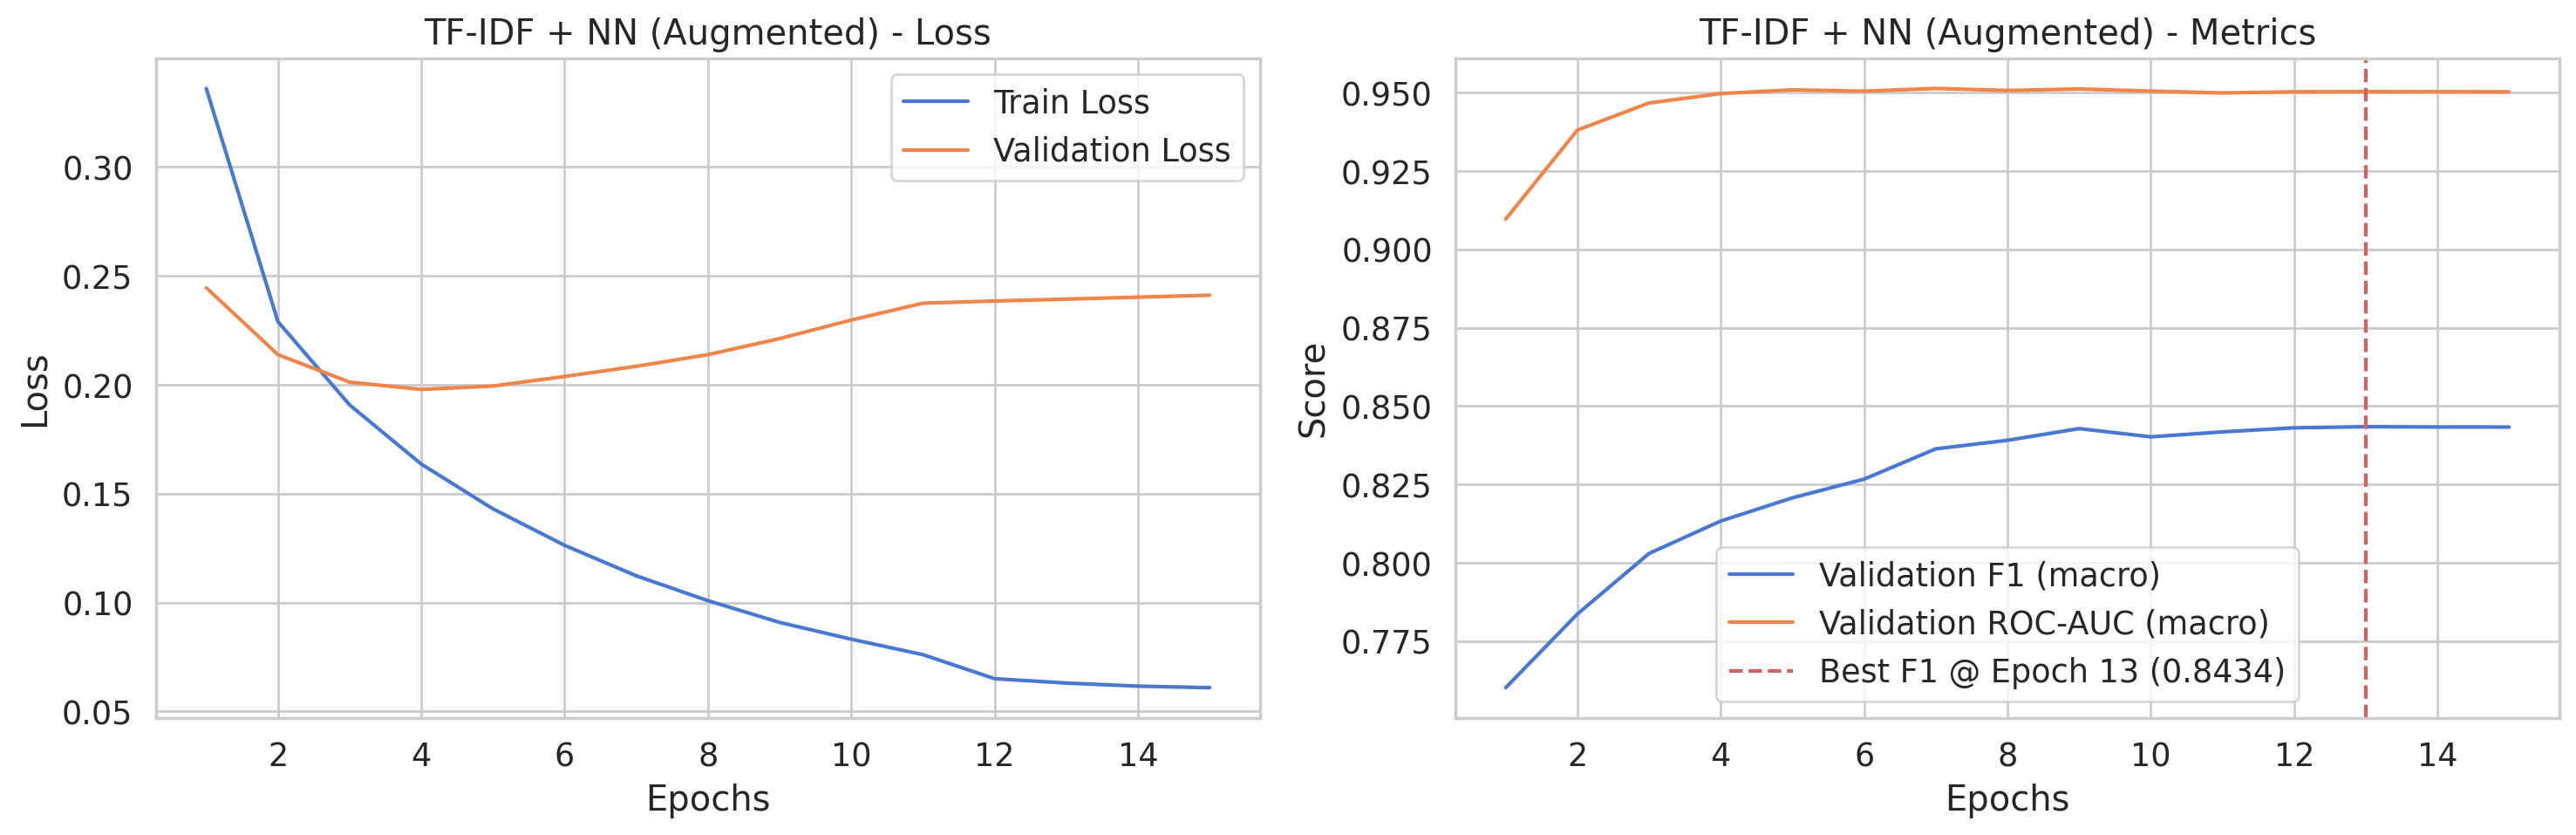

Лучший F1-macro для TF-IDF+NN (Augmented) на валидации: 0.8434


In [ ]:
print("\n--- Этап 4: Переобучение TF-IDF + NN на аугментированных данных ---")
input_dim_augmented = X_train_tfidf_augmented_tensor.shape[1]
model_tfidf_augmented = SimpleMLP(
    input_dim=input_dim_augmented,
    hidden_dim=256,
    output_dim=NUM_CLASSES
).to(device)
print("\nАрхитектура модели TF-IDF+NN (для аугментированных данных):")
print(model_tfidf_augmented)
criterion_augmented = nn.BCEWithLogitsLoss()
optimizer_tfidf_augmented = optim.Adam(model_tfidf_augmented.parameters(), lr=LEARNING_RATE_NN)
scheduler_tfidf_augmented = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_tfidf_augmented,
    mode='max',
    factor=0.1,
    patience=PATIENCE // 2,
    verbose=True
)
print("\nЗапуск обучения TF-IDF+NN на аугментированных данных...")
model_tfidf_augmented, history_tfidf_augmented, best_f1_tfidf_augmented = train_model(
    model=model_tfidf_augmented,
    model_name='tfidf_nn_augmented',
    train_loader=train_loader_tfidf_augmented,
    val_loader=val_loader_tfidf,
    optimizer=optimizer_tfidf_augmented,
    criterion=criterion_augmented,
    scheduler=scheduler_tfidf_augmented,
    num_epochs=EPOCHS,
    patience=PATIENCE,
    device=device
)
plot_history(history_tfidf_augmented, 'TF-IDF + NN (Augmented)')
print(f"Лучший F1-macro для TF-IDF+NN (Augmented) на валидации: {best_f1_tfidf_augmented:.4f}")

In [ ]:
print("\n--- Этап 4: Сравнение результатов и выводы по аугментации ---")
original_best_f1_tfidf = 0.8533
print(f"F1-macro на валидации (оригинальные данные): {original_best_f1_tfidf:.4f}")
print(f"F1-macro на валидации (аугментированные данные): {best_f1_tfidf_augmented:.4f}")
improvement = best_f1_tfidf_augmented - original_best_f1_tfidf
print(f"Изменение F1-macro после аугментации: {improvement:+.4f}")


--- Этап 4: Сравнение результатов и выводы по аугментации ---
F1-macro на валидации (оригинальные данные): 0.8533
F1-macro на валидации (аугментированные данные): 0.8434
Изменение F1-macro после аугментации: -0.0099


**Выводы по Этапу 4: Аугментация данных и оценка**

На данном этапе была предпринята попытка улучшить качество лучшей модели (TF-IDF + Нейронная сеть) с помощью аугментации данных. Аугментация проводилась путем генерации новых текстовых примеров с помощью обученной Seq2Seq модели (LabelEncoder + LSTM Decoder), которая училась генерировать тексты, соответствующие заданным векторам меток. Было сгенерировано 1000 дополнительных наблюдений, которые затем были добавлены к оригинальному обучающему набору.

**Результаты:**

*   **F1-macro на валидации (модель на оригинальных данных): 0.8533**
*   **F1-macro на валидации (модель на аугментированных данных): 0.8434**
*   **Изменение F1-macro после аугментации: -0.0099**

**Анализ результатов и выводы:**

1.  **Влияние аугментации:** В данном случае добавление 1000 синтетически сгенерированных примеров привело к **небольшому снижению** метрики F1-macro на валидационной выборке (на 0.0099). Это означает, что текущая стратегия аугментации не улучшила, а немного ухудшила обобщающую способность лучшей модели.

2.  **Возможные причины ухудшения/отсутствия улучшения:**
    *   **Качество сгенерированных текстов:** Сгенерированные тексты могли все еще быть недостаточно качественными. Они могли:
        *   Быть грамматически или семантически неидеальными.
        *   Содержать повторяющиеся паттерны или артефакты, свойственные генеративной модели.
        *   Недостаточно точно отражать специфику и разнообразие реальных текстов для соответствующих меток.
        
    *   **Объем аугментации:** 1000 примеров – это примерно 4.2% от оригинального размера `X_train` (23654 при test_size=0.2). Возможно, этот объем был недостаточен для значимого положительного влияния или, наоборот, если качество текстов было невысоким, этого объема хватило, чтобы внести некоторый шум.
    *   **Соответствие распределению:** Распределение сгенерированных данных (текстов и их связей с метками) могло не идеально совпадать с распределением реальных данных, что могло "сбить с толку" основную модель. Хотя метки сэмплировались из обучающего распределения, сами тексты могли отличаться.
    *   **Уже высокая производительность базовой модели:** Модель TF-IDF+NN уже показывала очень хороший результат (0.8533). Улучшить уже сильный бейзлайн с помощью простой генеративной аугментации может быть сложно.

3.  **Рекомендации на основе результатов:**
    *   Для финального предсказания (Этап 5) следует использовать **модель, обученную на оригинальных данных (`tfidf_nn_best.pth`)**, так как она показала лучший результат на валидационной выборке.
    *   Дальнейшие попытки аугментации потребовали бы значительного улучшения качества генератора (более глубокое обучение, другая архитектура, более тщательная настройка) или использования других, возможно, более простых и надежных методов аугментации текста (например, back-translation, если применимо, или синонимическая замена с контролем контекста).

**Общий итог этапа:** Эксперимент с аугментацией данных с помощью текущей конфигурации генератора не привел к улучшению производительности. Это подчеркивает, что успешная аугментация требует качественных синтетических данных, что само по себе является нетривиальной задачей. Тем не менее, сам пайплайн аугментации был реализован, что является ценным опытом.

In [ ]:
# Определение параметров для финального обучения и подготовка данных 
FINAL_EPOCHS = 25
FINAL_PATIENCE_SCHEDULER = 3
FINAL_PATIENCE_EARLY_STOP = 5

print("Подготовка TF-IDF для финальной модели...")
X_train['text_tfidf'] = X_train['text_tfidf'].fillna('')
X_val['text_tfidf'] = X_val['text_tfidf'].fillna('')
df_test['text_tfidf'] = df_test['text_tfidf'].fillna('')
tfidf_vectorizer_final = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 2)
)
print("Обучение TF-IDF векторайзера на X_train...")
X_train_tfidf_final = tfidf_vectorizer_final.fit_transform(X_train['text_tfidf'])
X_val_tfidf_final = tfidf_vectorizer_final.transform(X_val['text_tfidf'])
X_test_tfidf_final = tfidf_vectorizer_final.transform(df_test['text_tfidf'])
X_train_tfidf_tensor_final = torch.tensor(X_train_tfidf_final.toarray(), dtype=torch.float32)
X_val_tfidf_tensor_final = torch.tensor(X_val_tfidf_final.toarray(), dtype=torch.float32)
X_test_tfidf_tensor_final = torch.tensor(X_test_tfidf_final.toarray(), dtype=torch.float32)

print(f"Размерность TF-IDF (Train final): {X_train_tfidf_tensor_final.shape}")
print(f"Размерность TF-IDF (Val final): {X_val_tfidf_tensor_final.shape}")
print(f"Размерность TF-IDF (Test final): {X_test_tfidf_tensor_final.shape}")

train_dataset_final = SimpleDataset(X_train_tfidf_tensor_final, y_train_tensor)
val_dataset_final = SimpleDataset(X_val_tfidf_tensor_final, y_val_tensor)
dummy_labels_test = torch.zeros(X_test_tfidf_tensor_final.shape[0], NUM_CLASSES, dtype=torch.float32)
test_dataset_final = SimpleDataset(X_test_tfidf_tensor_final, dummy_labels_test)
train_loader_final = DataLoader(train_dataset_final, batch_size=BATCH_SIZE, shuffle=True)
val_loader_final = DataLoader(val_dataset_final, batch_size=BATCH_SIZE, shuffle=False)
test_loader_final = DataLoader(test_dataset_final, batch_size=BATCH_SIZE, shuffle=False)

print("Данные для финального обучения и предсказания готовы.")

Подготовка TF-IDF для финальной модели...
Обучение TF-IDF векторайзера на X_train...
Размерность TF-IDF (Train final): torch.Size([23654, 15000])
Размерность TF-IDF (Val final): torch.Size([5914, 15000])
Размерность TF-IDF (Test final): torch.Size([7392, 15000])
Данные для финального обучения и предсказания готовы.



--- Этап 5: Обучение финальной модели TF-IDF + NN ---

Архитектура финальной модели TF-IDF+NN:
SimpleMLP(
  (fc1): Linear(in_features=15000, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=20, bias=True)
)

Запуск обучения финальной модели...


Epoch 1/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 1/25 | Time: 7.27s | Train Loss: 0.3250 | Val Loss: 0.2377 | Val F1: 0.7516 | Val ROC-AUC: 0.9101
Validation F1 improved (-1.0000 --> 0.7516). Saving model...


Epoch 2/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 2/25 | Time: 9.36s | Train Loss: 0.2077 | Val Loss: 0.2055 | Val F1: 0.7952 | Val ROC-AUC: 0.9414
Validation F1 improved (0.7516 --> 0.7952). Saving model...


Epoch 3/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 3/25 | Time: 5.31s | Train Loss: 0.1685 | Val Loss: 0.1918 | Val F1: 0.8102 | Val ROC-AUC: 0.9496
Validation F1 improved (0.7952 --> 0.8102). Saving model...


Epoch 4/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 4/25 | Time: 3.88s | Train Loss: 0.1428 | Val Loss: 0.1868 | Val F1: 0.8204 | Val ROC-AUC: 0.9534
Validation F1 improved (0.8102 --> 0.8204). Saving model...


Epoch 5/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 5/25 | Time: 4.50s | Train Loss: 0.1231 | Val Loss: 0.1877 | Val F1: 0.8266 | Val ROC-AUC: 0.9549
Validation F1 improved (0.8204 --> 0.8266). Saving model...


Epoch 6/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 6/25 | Time: 3.86s | Train Loss: 0.1077 | Val Loss: 0.1904 | Val F1: 0.8294 | Val ROC-AUC: 0.9557
Validation F1 improved (0.8266 --> 0.8294). Saving model...


Epoch 7/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 7/25 | Time: 3.89s | Train Loss: 0.0946 | Val Loss: 0.1945 | Val F1: 0.8342 | Val ROC-AUC: 0.9562
Validation F1 improved (0.8294 --> 0.8342). Saving model...


Epoch 8/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 8/25 | Time: 4.22s | Train Loss: 0.0838 | Val Loss: 0.1999 | Val F1: 0.8393 | Val ROC-AUC: 0.9561
Validation F1 improved (0.8342 --> 0.8393). Saving model...


Epoch 9/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 9/25 | Time: 4.13s | Train Loss: 0.0744 | Val Loss: 0.2059 | Val F1: 0.8402 | Val ROC-AUC: 0.9562
Validation F1 improved (0.8393 --> 0.8402). Saving model...


Epoch 10/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 10/25 | Time: 3.85s | Train Loss: 0.0673 | Val Loss: 0.2143 | Val F1: 0.8393 | Val ROC-AUC: 0.9557
Validation F1 did not improve from 0.8402. (1/5)


Epoch 11/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 11/25 | Time: 3.93s | Train Loss: 0.0611 | Val Loss: 0.2225 | Val F1: 0.8437 | Val ROC-AUC: 0.9550
Validation F1 improved (0.8402 --> 0.8437). Saving model...


Epoch 12/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 12/25 | Time: 4.49s | Train Loss: 0.0551 | Val Loss: 0.2298 | Val F1: 0.8442 | Val ROC-AUC: 0.9548
Validation F1 improved (0.8437 --> 0.8442). Saving model...


Epoch 13/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 13/25 | Time: 3.89s | Train Loss: 0.0499 | Val Loss: 0.2383 | Val F1: 0.8503 | Val ROC-AUC: 0.9540
Validation F1 improved (0.8442 --> 0.8503). Saving model...


Epoch 14/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 14/25 | Time: 3.85s | Train Loss: 0.0462 | Val Loss: 0.2464 | Val F1: 0.8533 | Val ROC-AUC: 0.9536
Validation F1 improved (0.8503 --> 0.8533). Saving model...


Epoch 15/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 15/25 | Time: 4.23s | Train Loss: 0.0426 | Val Loss: 0.2560 | Val F1: 0.8487 | Val ROC-AUC: 0.9530
Validation F1 did not improve from 0.8533. (1/5)


Epoch 16/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 16/25 | Time: 4.30s | Train Loss: 0.0399 | Val Loss: 0.2648 | Val F1: 0.8488 | Val ROC-AUC: 0.9526
Validation F1 did not improve from 0.8533. (2/5)


Epoch 17/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 17/25 | Time: 4.09s | Train Loss: 0.0369 | Val Loss: 0.2713 | Val F1: 0.8523 | Val ROC-AUC: 0.9517
Validation F1 did not improve from 0.8533. (3/5)


Epoch 18/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 18/25 | Time: 3.93s | Train Loss: 0.0342 | Val Loss: 0.2790 | Val F1: 0.8482 | Val ROC-AUC: 0.9511
Validation F1 did not improve from 0.8533. (4/5)


Epoch 19/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 19/25 | Time: 4.47s | Train Loss: 0.0285 | Val Loss: 0.2795 | Val F1: 0.8481 | Val ROC-AUC: 0.9513
Validation F1 did not improve from 0.8533. (5/5)
Early stopping triggered after 19 epochs.
Loading best model weights from tfidf_nn_final_best.pth (Val F1: 0.8533)


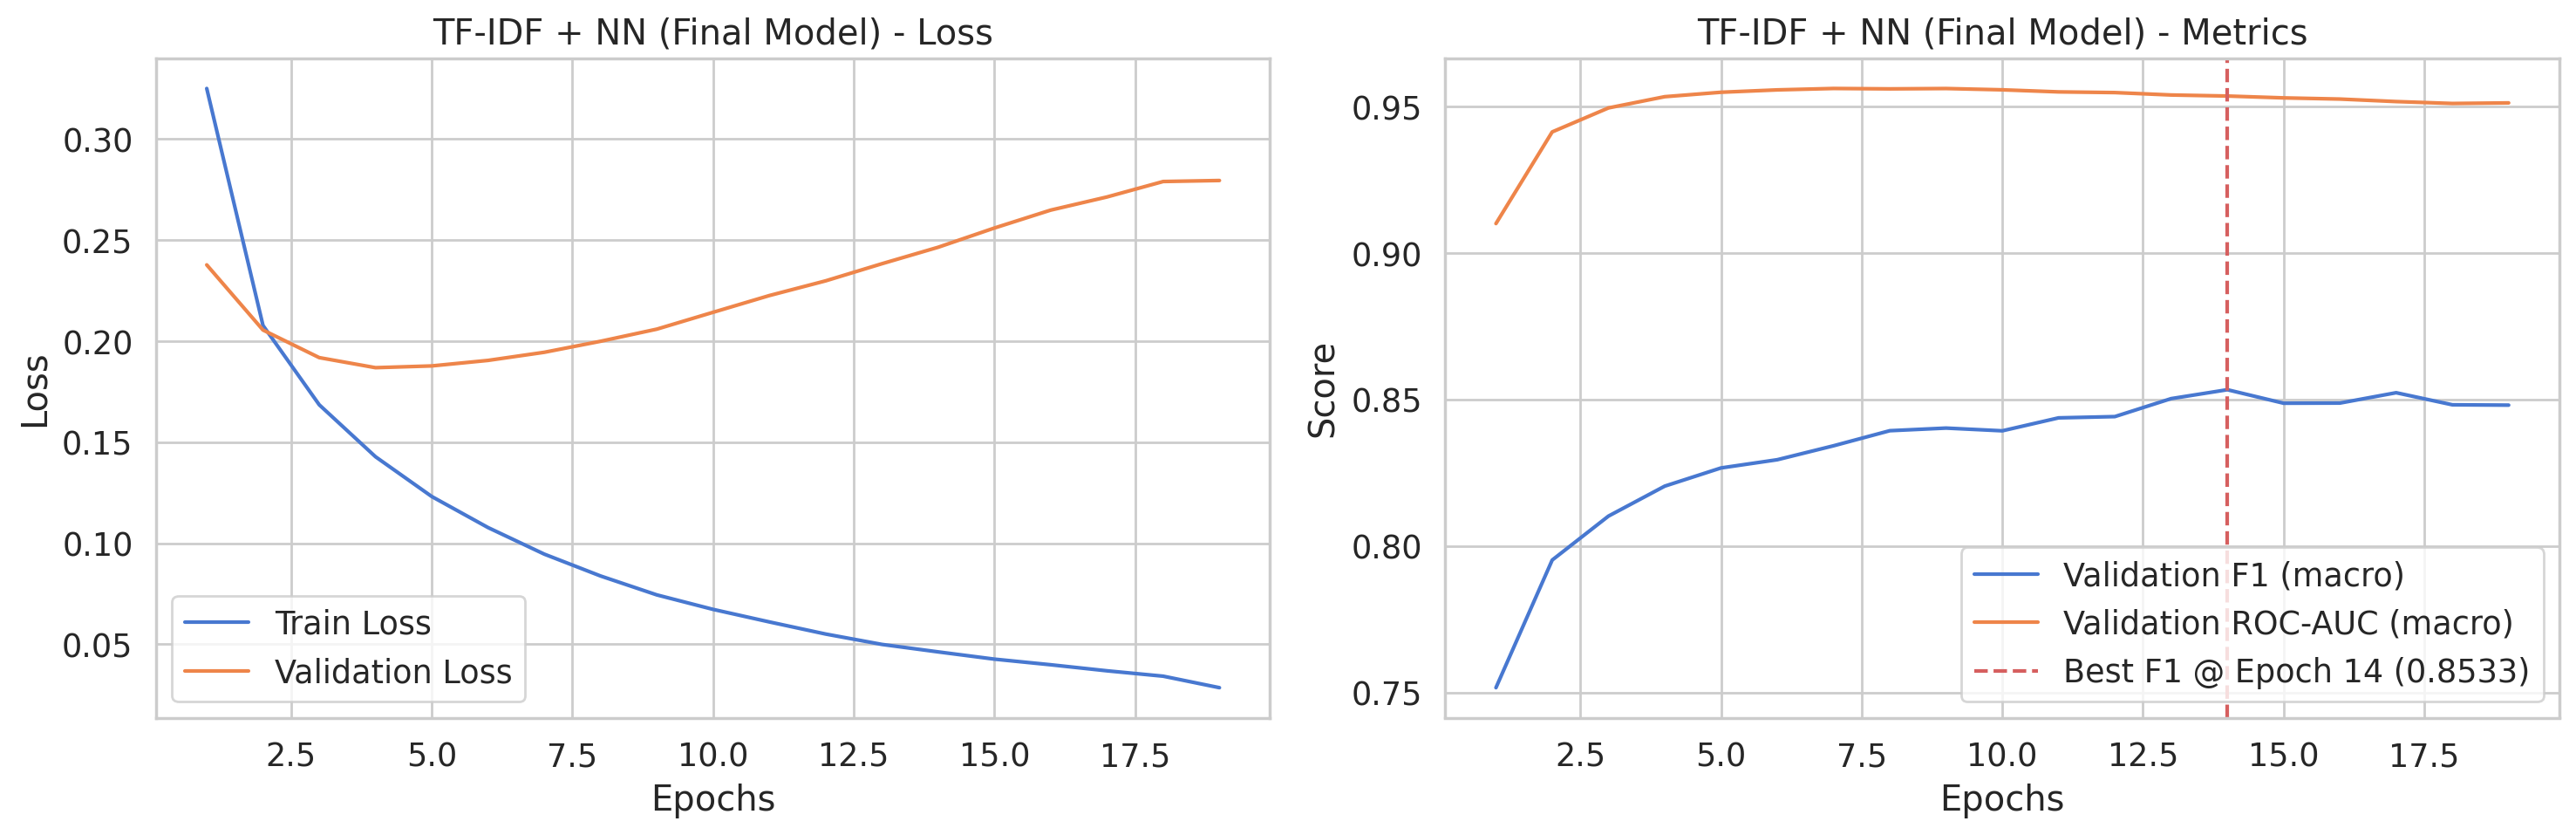

Лучший F1-macro для финальной модели TF-IDF+NN на валидации: 0.8533


In [ ]:

print("\n--- Этап 5: Обучение финальной модели TF-IDF + NN ---")

input_dim_final = X_train_tfidf_tensor_final.shape[1]
final_model = SimpleMLP(
    input_dim=input_dim_final,
    hidden_dim=256,
    output_dim=NUM_CLASSES,
    dropout_rate=0.3
).to(device)

print("\nАрхитектура финальной модели TF-IDF+NN:")
print(final_model)


criterion_final = nn.BCEWithLogitsLoss()
optimizer_final = optim.Adam(final_model.parameters(), lr=LEARNING_RATE_NN)
scheduler_final = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_final,
    mode='max',
    factor=0.1,
    patience=FINAL_PATIENCE_SCHEDULER,
    verbose=True
)

print("\nЗапуск обучения финальной модели...")
final_model, history_final, best_f1_final_model = train_model(
    model=final_model,
    model_name='tfidf_nn_final',
    train_loader=train_loader_final,
    val_loader=val_loader_final,
    optimizer=optimizer_final,
    criterion=criterion_final,
    scheduler=scheduler_final,
    num_epochs=FINAL_EPOCHS,
    patience=FINAL_PATIENCE_EARLY_STOP,
    device=device
)

plot_history(history_final, 'TF-IDF + NN (Final Model)')
print(f"Лучший F1-macro для финальной модели TF-IDF+NN на валидации: {best_f1_final_model:.4f}")

In [ ]:
print("\n--- Этап 5: Оптимизация порога для бинаризации ---")

final_model.eval()
all_val_preds_logits_final = []
all_val_labels_final = []

with torch.no_grad():
    for features, labels in tqdm(val_loader_final, desc="Получение предсказаний на Val для оптимизации порога"):
        features = features.to(device)

        outputs = final_model(features)
        all_val_preds_logits_final.append(outputs.cpu())
        all_val_labels_final.append(labels)

val_preds_logits_for_threshold = torch.cat(all_val_preds_logits_final, dim=0)
val_labels_for_threshold = torch.cat(all_val_labels_final, dim=0)
val_probs_for_threshold = torch.sigmoid(val_preds_logits_for_threshold)

print("\nПоиск оптимального порога (глобального)...")
best_threshold = 0.5
best_f1_at_threshold = 0.0

for threshold_candidate in np.arange(0.1, 0.91, 0.01):
    temp_f1, _ = calculate_metrics(val_labels_for_threshold, val_preds_logits_for_threshold, threshold=threshold_candidate)
    if temp_f1 > best_f1_at_threshold:
        best_f1_at_threshold = temp_f1
        best_threshold = threshold_candidate

print(f"Лучший глобальный порог: {best_threshold:.2f} с F1-macro: {best_f1_at_threshold:.4f} на валидации.")

FINAL_THRESHOLD = best_threshold


--- Этап 5: Оптимизация порога для бинаризации ---


Получение предсказаний на Val для оптимизации порога:   0%|          | 0/185 [00:00<?, ?it/s]


Поиск оптимального порога (глобального)...
Лучший глобальный порог: 0.33 с F1-macro: 0.8567 на валидации.


In [ ]:
print("\n--- Этап 5: Предсказание на тестовой выборке и создание submission ---")

final_model.eval()
all_test_preds_logits = []

with torch.no_grad():
    for features, _ in tqdm(test_loader_final, desc="Предсказание на тестовой выборке"):
        features = features.to(device)
        outputs = final_model(features)
        all_test_preds_logits.append(outputs.cpu())

test_predictions_logits = torch.cat(all_test_preds_logits, dim=0)
test_probs = torch.sigmoid(test_predictions_logits)

test_predicted_labels_binary = (test_probs.numpy() >= FINAL_THRESHOLD).astype(int)

predicted_labels_str_list = [" ".join(map(str, row)) for row in test_predicted_labels_binary]


submission_df = pd.DataFrame({
    'id': df_test['id'],
    'labels': predicted_labels_str_list
})

submission_filename = 'submission_final_tfidf_nn.csv'
submission_df.to_csv(submission_filename, index=False)
print(f"\nФайл {submission_filename} успешно создан.")
display(submission_df.head())

if len(submission_df) == len(df_test):
    print(f"Количество строк в submission ({len(submission_df)}) совпадает с тестовой выборкой.")
else:
    print(f"ПРЕДУПРЕЖДЕНИЕ: Количество строк в submission ({len(submission_df)}) НЕ совпадает с тестовой выборкой ({len(df_test)}).")


--- Этап 5: Предсказание на тестовой выборке и создание submission ---


Предсказание на тестовой выборке:   0%|          | 0/231 [00:00<?, ?it/s]


Файл submission_final_tfidf_nn.csv успешно создан.


id                                   labels
0  29568  1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
1  29569  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
2  29570  0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
3  29571  1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0
4  29572  0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1

Количество строк в submission (7392) совпадает с тестовой выборкой.
